# Inspect the single-lineage model run on the prostate data (008)

 Model attributes:

- sgRNA | gene varying intercept
- RNA and CN varying effects per gene
- correlation between gene varying effects modeled using the multivariate normal and Cholesky decomposition (non-centered parameterization)
- target gene mutation variable and cancer gene comutation variable.
- varying intercept and slope for copy number for chromosome nested with in cell line

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager, broad_only
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"
arviz_config()

## Data

In [5]:
saved_model_dir = models_dir() / "hnb-single-lineage-prostate-008_PYMC_NUMPYRO"

In [6]:
with open(saved_model_dir / "description.txt") as f:
    model_description = "".join(list(f))

print(model_description)

config. name: 'hnb-single-lineage-prostate-008'
model name: 'LineageHierNegBinomModel'
model version: '0.0.3'
model description: A hierarchical negative binomial generalized linear model fora single lineage.fit method: 'PYMC_NUMPYRO'

--------------------------------------------------------------------------------

CONFIGURATION

{
    "name": "hnb-single-lineage-prostate-008",
    "description": " Single lineage hierarchical negative binomial model for prostate data from the Broad.\nVarying effects for each chromosome of each cell line has been nested under the existing varying effects for cell line. ",
    "active": true,
    "model": "LINEAGE_HIERARCHICAL_NB",
    "data_file": "modeling_data/lineage-modeling-data/depmap-modeling-data_prostate.csv",
    "model_kwargs": {
        "lineage": "prostate"
    },
    "sampling_kwargs": {
        "pymc_mcmc": null,
        "pymc_advi": null,
        "pymc_numpyro": {
            "draws": 1000,
            "tune": 1500,
            "chains":

### Load posterior summary

In [7]:
prostate_post_summary = pd.read_csv(saved_model_dir / "posterior-summary.csv").assign(
    var_name=lambda d: [x.split("[")[0] for x in d["parameter"]]
)
prostate_post_summary.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0   mu_mu_a  0.102  0.023     0.066      0.119      0.009    0.007       6.0   
1      mu_b  0.006  0.006     0.001      0.016      0.003    0.002       5.0   
2   mu_mu_m -0.275  0.084    -0.326     -0.145      0.037    0.030       5.0   
3   sigma_a  0.053  0.092     0.000      0.212      0.046    0.035       4.0   
4   sigma_k  0.009  0.014     0.000      0.033      0.007    0.005       4.0   

   ess_tail  r_hat var_name  
0      34.0   2.55  mu_mu_a  
1      11.0   3.15     mu_b  
2      12.0   3.26  mu_mu_m  
3       4.0   3.55  sigma_a  
4       4.0   3.60  sigma_k

### Load trace object

In [8]:
trace_file = saved_model_dir / "posterior.netcdf"
assert trace_file.exists()
trace = az.from_netcdf(trace_file)

### Prostate data

In [9]:
prostate_dm = CrisprScreenDataManager(
    modeling_data_dir() / "lineage-modeling-data" / "depmap-modeling-data_prostate.csv",
    transformations=[broad_only],
)

In [10]:
prostate_data = prostate_dm.get_data(read_kwargs={"low_memory": False})
prostate_data.head()

sgrna                 replicate_id       lfc p_dna_batch  \
0  AAAGCCCAGGAGTATGGGAG  Vcap-304Cas9_RepA_p4_batch3  0.246450           3   
1  AAATCAGAGAAACCTGAACG  Vcap-304Cas9_RepA_p4_batch3  0.626518           3   
2  AACGTCTTTGAAGAAAGCTG  Vcap-304Cas9_RepA_p4_batch3  0.165114           3   
3  AACGTCTTTGAAGGAAGCTG  Vcap-304Cas9_RepA_p4_batch3 -0.094688           3   
4  AAGAGGTTCCAGACTACTTA  Vcap-304Cas9_RepA_p4_batch3  0.294496           3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_130522105_-       CFC1B  broad                   True   
1  chr11_89916950_-    TRIM49D1  broad                   True   
2   chr5_71055421_-      GTF2H2  broad                   True   
3   chr5_69572480_+     GTF2H2C  broad                   True   
4  chrX_155898173_+       VAMP7  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                2         130522105  ...             NaN               NaN   
1               11          89916950  ...             NaN               NaN   
2                5          71055421  ...             NaN               NaN   
3                5          69572480  ...             NaN               NaN   
4                X         155898173  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number   lineage  \
0                 NaN       False     0.999455  prostate   
1                 NaN       False     1.281907  prostate   
2                 NaN       False     0.616885  prostate   
3                 NaN       False     0.616885  prostate   
4                 NaN       False     0.615935  prostate   

           lineage_subtype primary_or_metastasis  is_male   age  
0  prostate_adenocarcinoma            metastasis     True  59.0  
1  prostate_adenocarcinoma            metastasis     True  59.0  
2  prostate_adenocarcinoma            metastasis     True  59.0  
3  prostate_adenocarcinoma            metastasis     True  59.0  
4  prostate_adenocarcinoma            metastasis     True  59.0  

[5 rows x 25 columns]

### Single lineage model

In [11]:
prostate_model = LineageHierNegBinomModel(lineage="prostate")

In [12]:
valid_prostate_data = prostate_model.data_processing_pipeline(prostate_data.copy())
prostate_mdl_data = prostate_model.make_data_structure(valid_prostate_data)

[INFO] 2022-08-08 09:02:37 [(lineage_hierarchical_nb.py:data_processing_pipeline:317] Processing data for modeling.
[INFO] 2022-08-08 09:02:37 [(lineage_hierarchical_nb.py:data_processing_pipeline:318] LFC limits: (-5.0, 5.0)
[WARNING] 2022-08-08 09:03:57 [(lineage_hierarchical_nb.py:data_processing_pipeline:376] number of data points dropped: 2
[INFO] 2022-08-08 09:03:57 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:587] number of genes mutated in all cells lines: 0
[DEBUG] 2022-08-08 09:03:57 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:590] Genes always mutated: 
[DEBUG] 2022-08-08 09:03:57 [(cancer_gene_mutation_matrix.py:_trim_cancer_genes:68] all_mut: {}
[INFO] 2022-08-08 09:03:57 [(cancer_gene_mutation_matrix.py:_trim_cancer_genes:77] Dropping 8 cancer genes.
[DEBUG] 2022-08-08 09:03:57 [(cancer_gene_mutation_matrix.py:_trim_cancer_genes:79] Dropped cancer genes: ['AR', 'AXIN1', 'FOXA1', 'KLF6', 'NCOR2', 'PTEN', 'SALL4', 'SPOP']


## Analysis

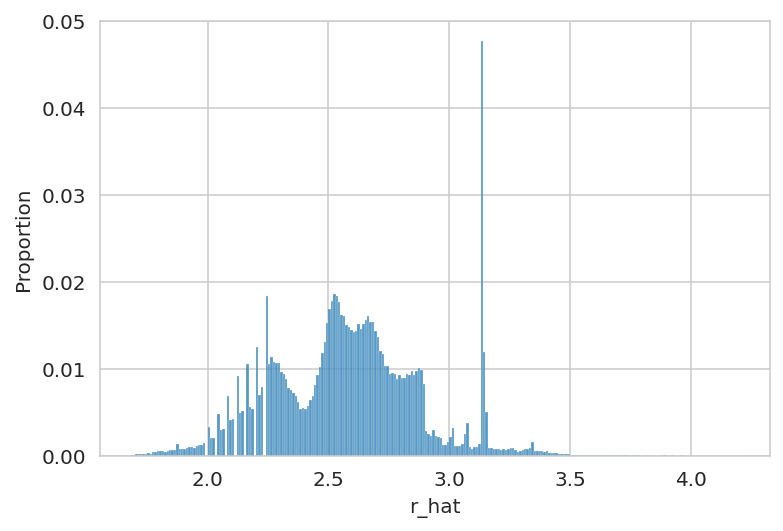

In [13]:
sns.histplot(x=prostate_post_summary["r_hat"], binwidth=0.01, stat="proportion");

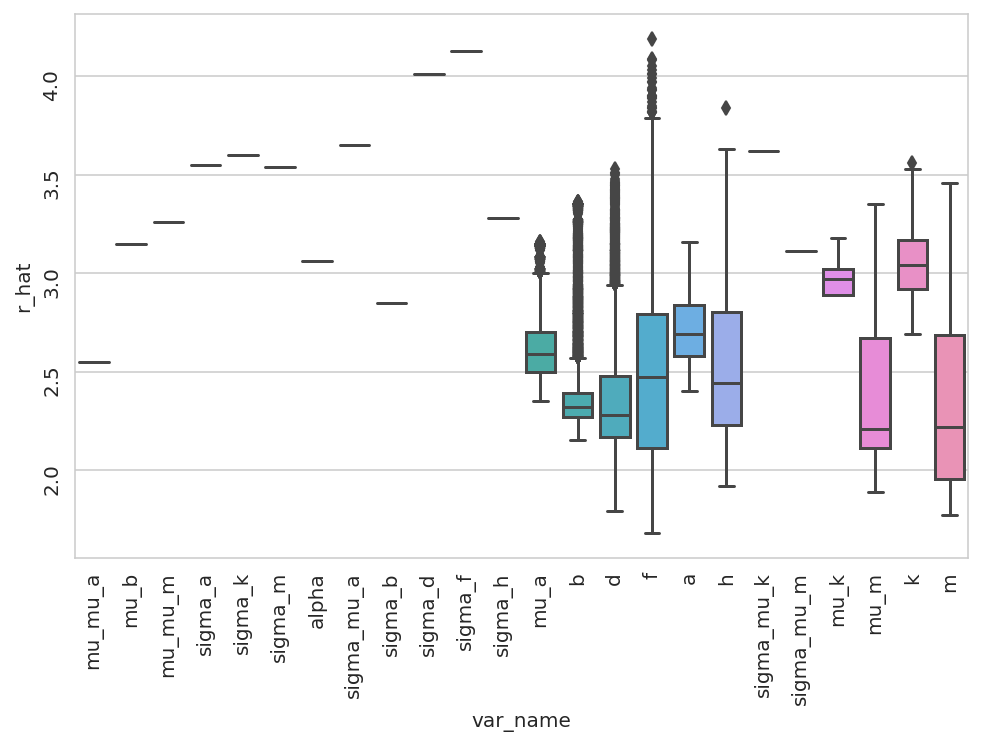

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=prostate_post_summary, x="var_name", y="r_hat", ax=ax)
ax.tick_params(rotation=90)
plt.show()

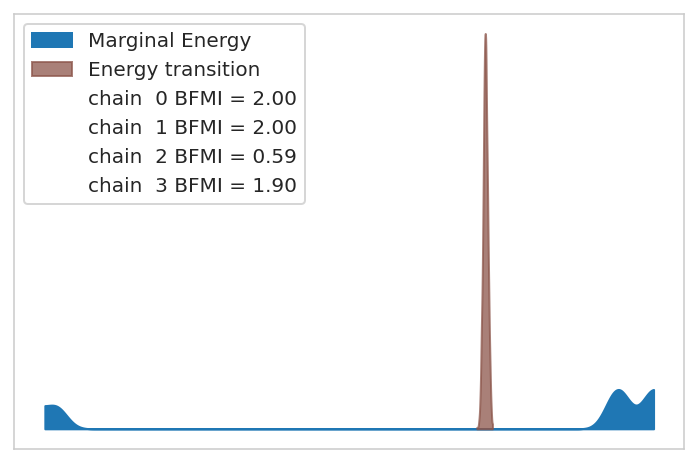

In [15]:
az.plot_energy(trace);

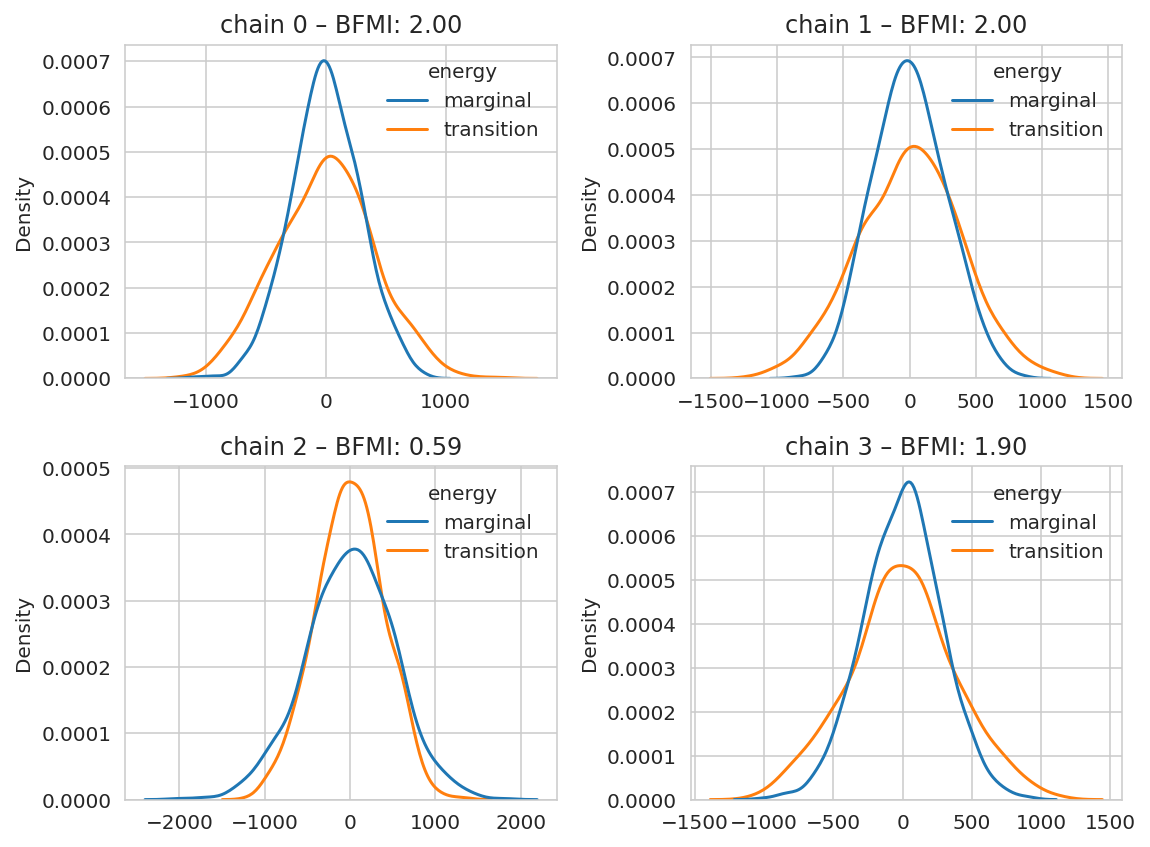

In [16]:
energy = trace.sample_stats.energy.values
marginal_e = pd.DataFrame((energy - energy.mean(axis=1)[:, None]).T).assign(
    energy="marginal"
)
transition_e = pd.DataFrame((energy[:, :-1] - energy[:, 1:]).T).assign(
    energy="transition"
)
energy_df = pd.concat([marginal_e, transition_e]).reset_index(drop=True)
bfmi = az.bfmi(trace)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(data=energy_df, x=i, hue="energy", ax=ax)
    ax.set_title(f"chain {i} – BFMI: {bfmi[i]:0.2f}")
    ax.set_xlabel(None)
    xmin, _ = ax.get_xlim()
    _, ymax = ax.get_ylim()
    ax.get_legend().set_frame_on(False)

fig.tight_layout()
plt.show()

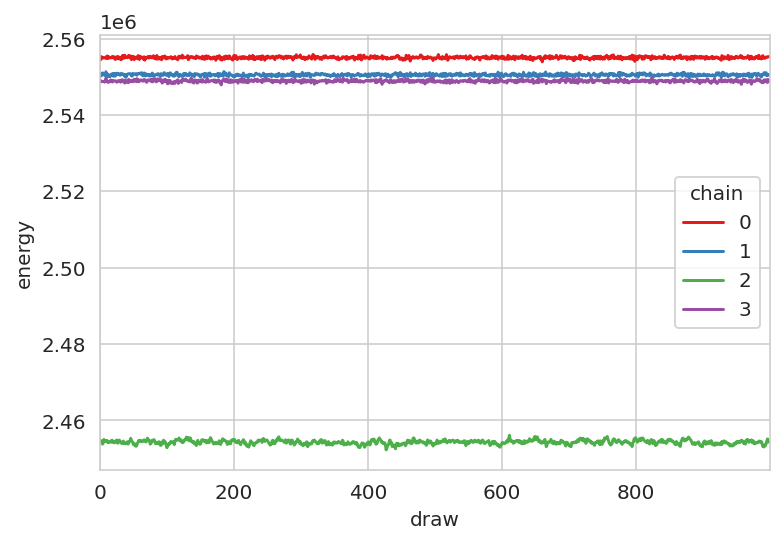

In [17]:
hmc_energy = (
    trace.sample_stats.get("energy")
    .to_dataframe()
    .reset_index(drop=False)
    .astype({"chain": "category"})
)
ax = sns.lineplot(data=hmc_energy, x="draw", y="energy", hue="chain", palette="Set1")
ax.set_xlim(0, hmc_energy["draw"].max())
plt.show()

In [18]:
stats = ["step_size", "n_steps", "tree_depth", "acceptance_rate", "energy"]
trace.sample_stats.get(stats).to_dataframe().groupby("chain").mean()

step_size  n_steps  tree_depth  acceptance_rate        energy
chain                                                                  
0      1.599252e-10   2047.0        11.0         0.980880  2.555008e+06
1      2.494715e-14   2047.0        11.0         0.987095  2.550493e+06
2      2.656016e-03   2047.0        11.0         0.987374  2.454301e+06
3      1.294592e-08   2047.0        11.0         0.974076  2.548882e+06

In [19]:
HAPPY_CHAINS = [2]

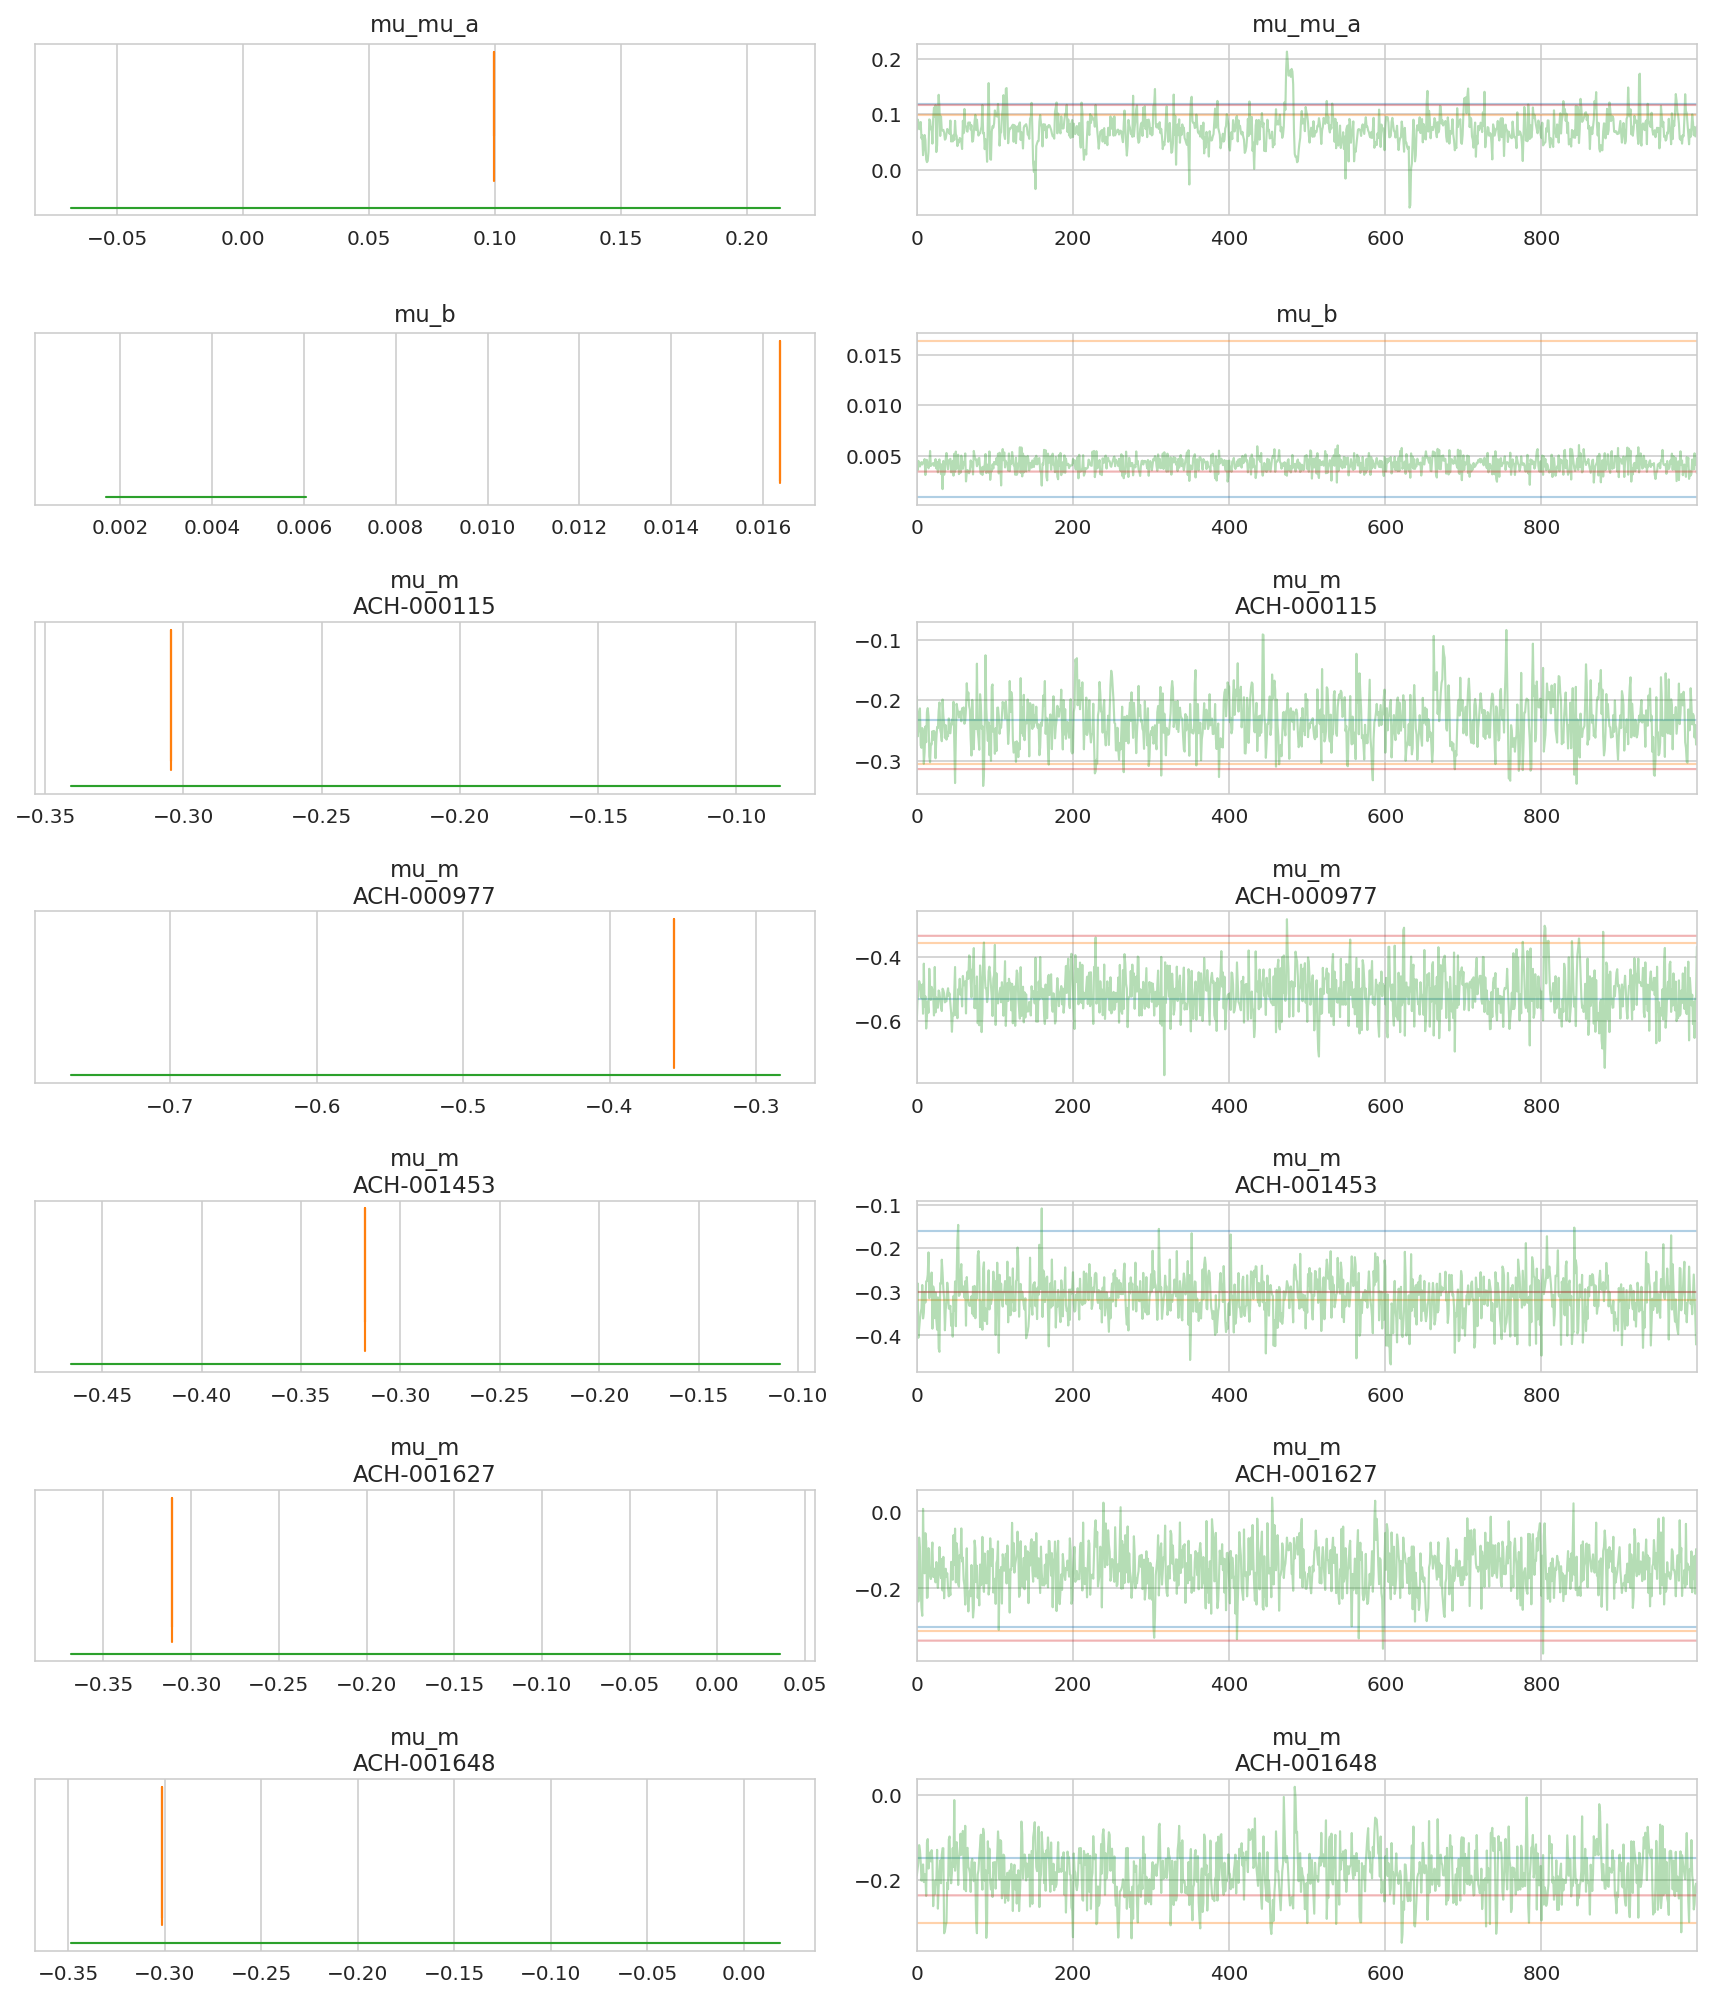

In [20]:
az.plot_trace(trace, var_names=["mu_mu_a", "mu_b", "mu_m"], compact=False)
plt.tight_layout()
plt.show()

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/hom

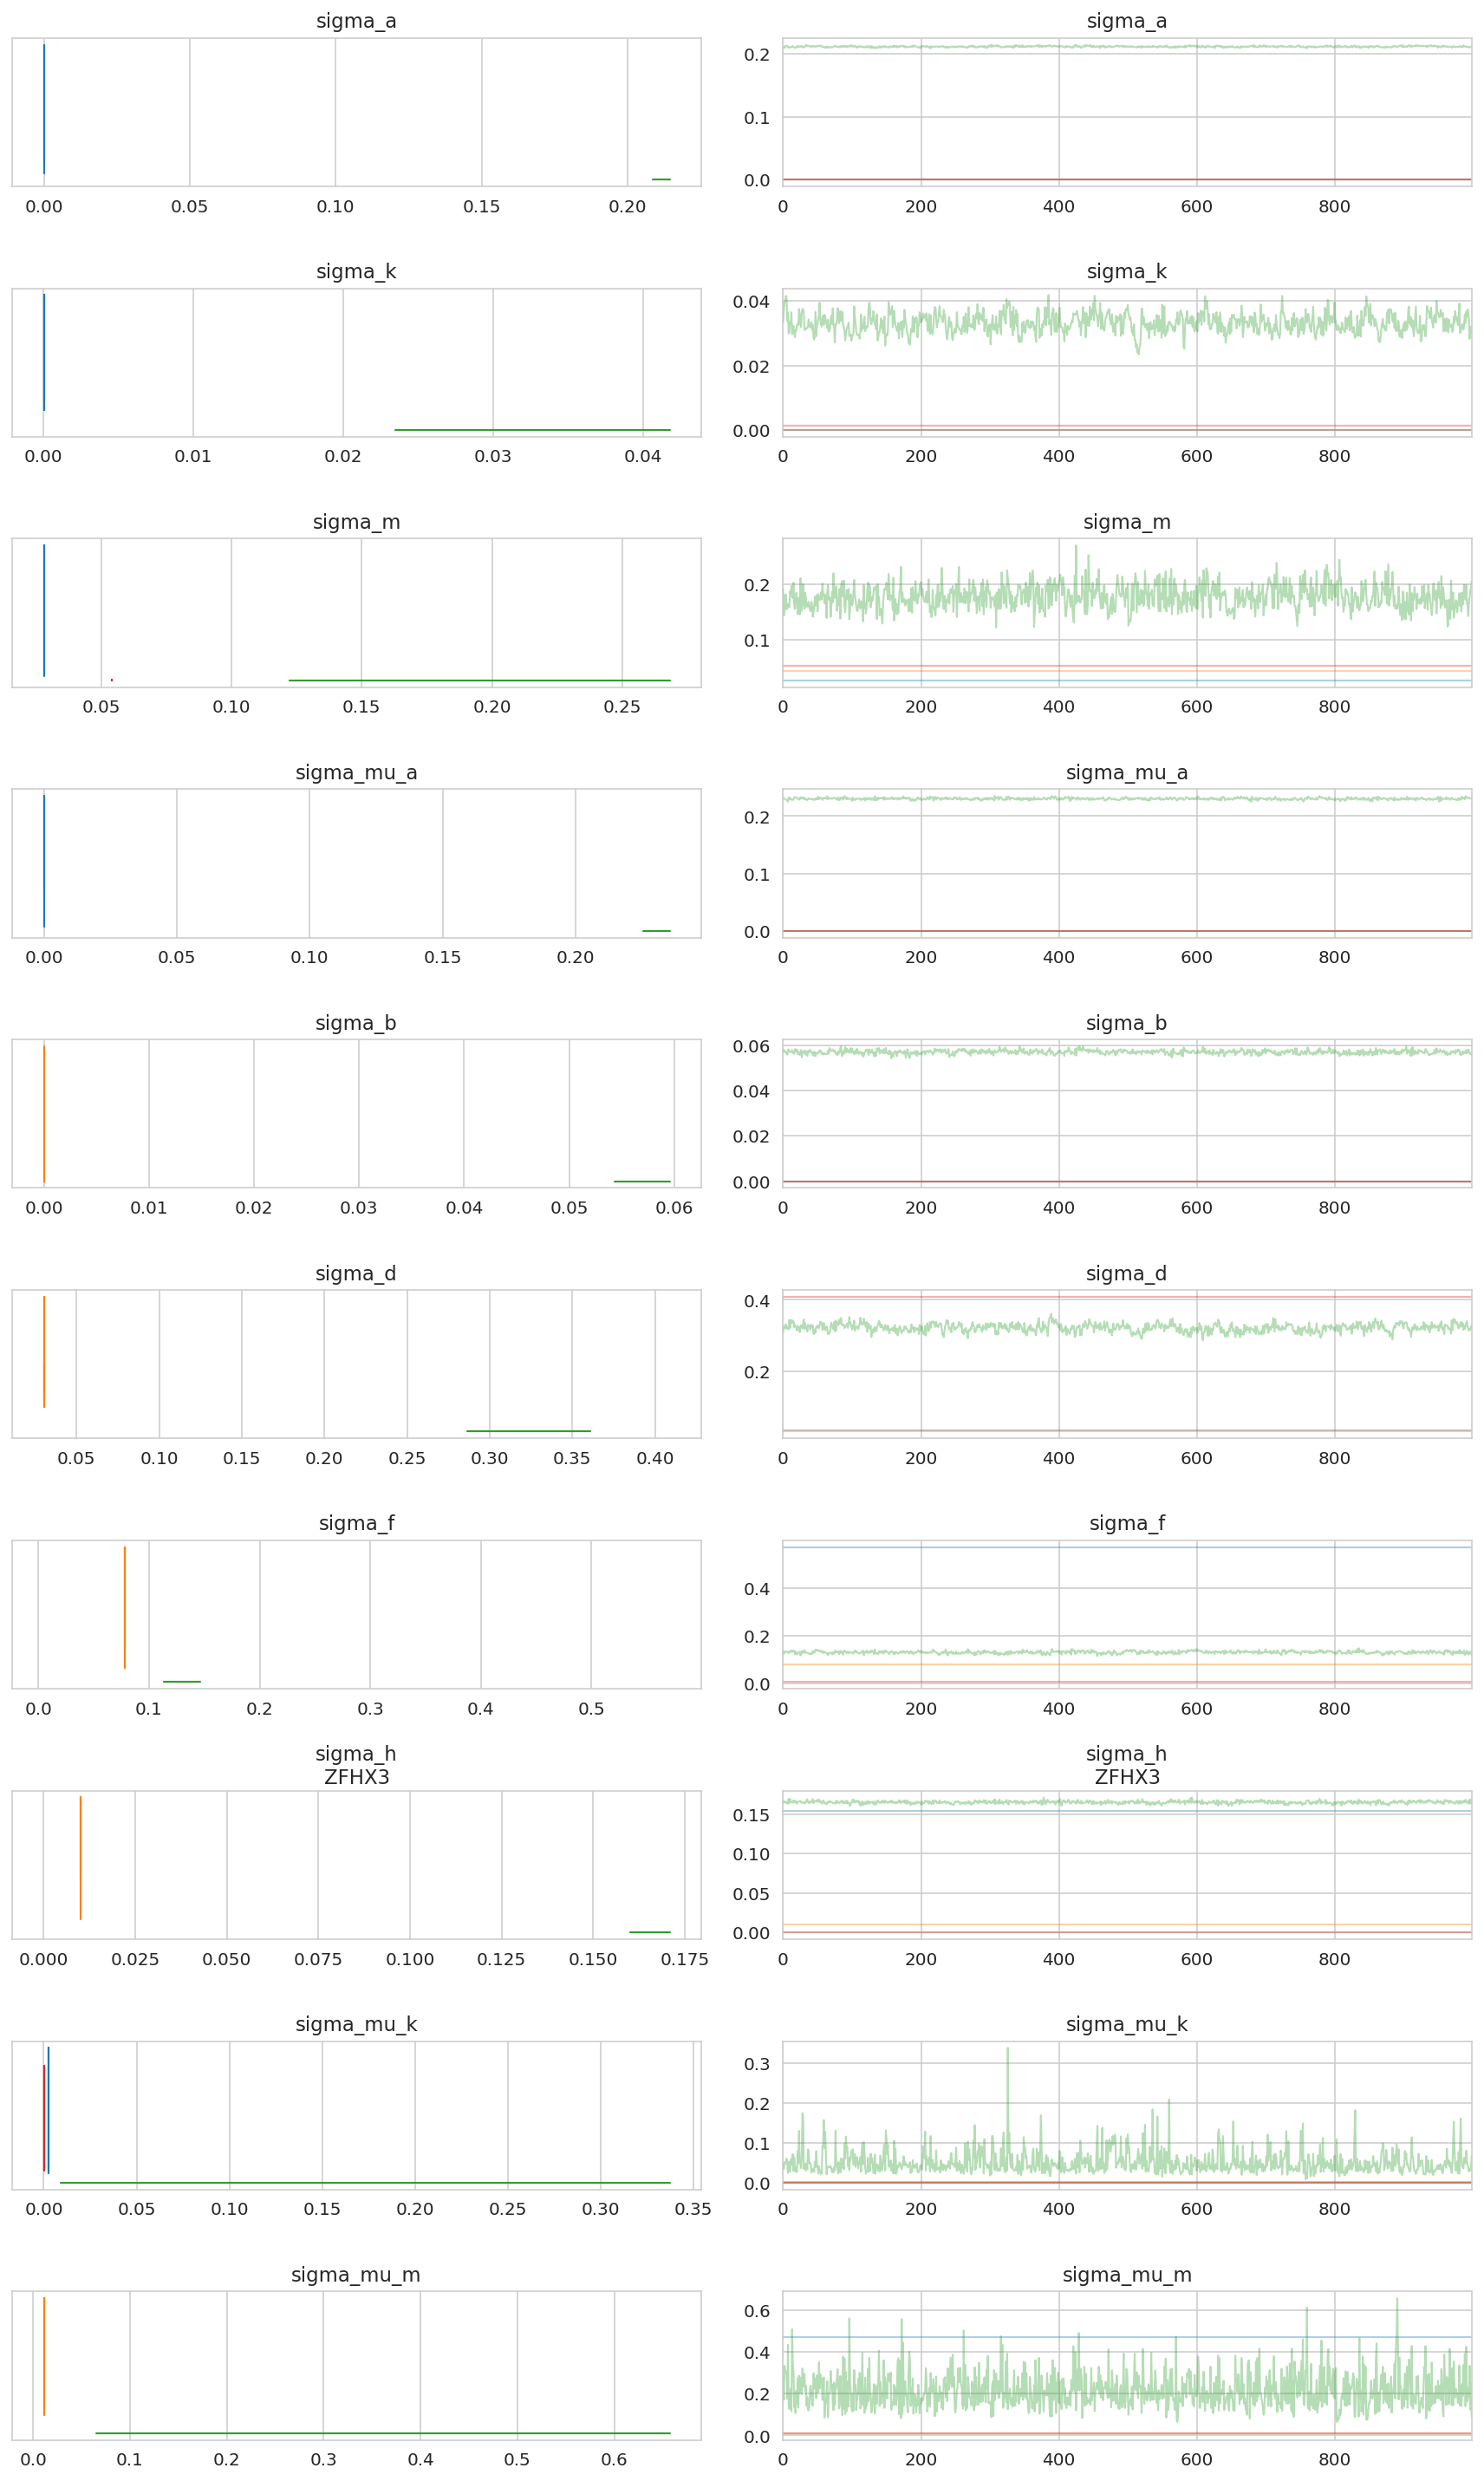

In [21]:
az.plot_trace(trace, var_names=["^sigma_*"], filter_vars="regex", compact=False)
plt.tight_layout()

In [22]:
sigmas = ["sigma_mu_a", "sigma_b", "sigma_d", "sigma_f", "sigma_k"]
trace.posterior.get(sigmas).mean(dim="draw").to_dataframe()

sigma_mu_a       sigma_b   sigma_d   sigma_f       sigma_k
chain                                                              
0      3.350969e-14  1.602743e-12  0.033105  0.570832  1.047392e-05
1      1.621624e-12  2.806242e-16  0.030183  0.078072  2.914971e-11
2      2.303786e-01  5.700978e-02  0.321644  0.129522  3.312310e-02
3      7.609938e-09  1.138677e-10  0.408969  0.004811  1.384195e-03

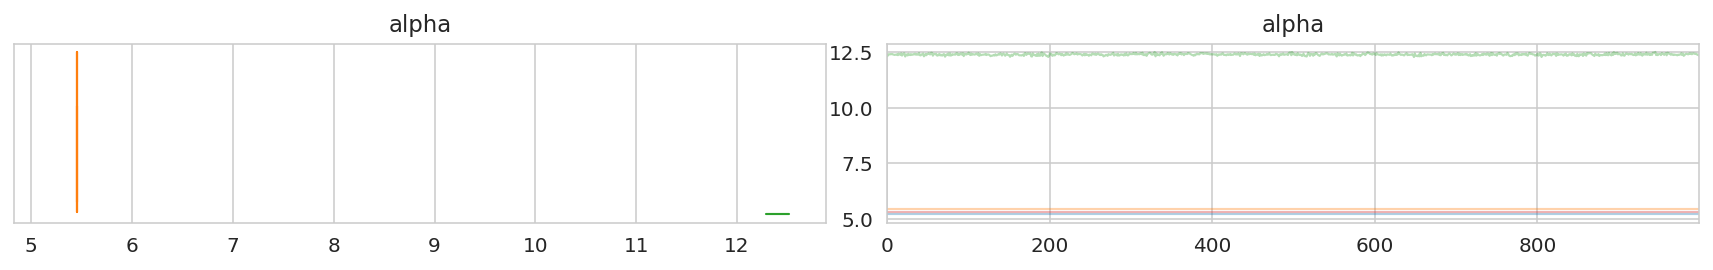

In [23]:
az.plot_trace(trace, var_names=["alpha"], compact=False)
plt.tight_layout()

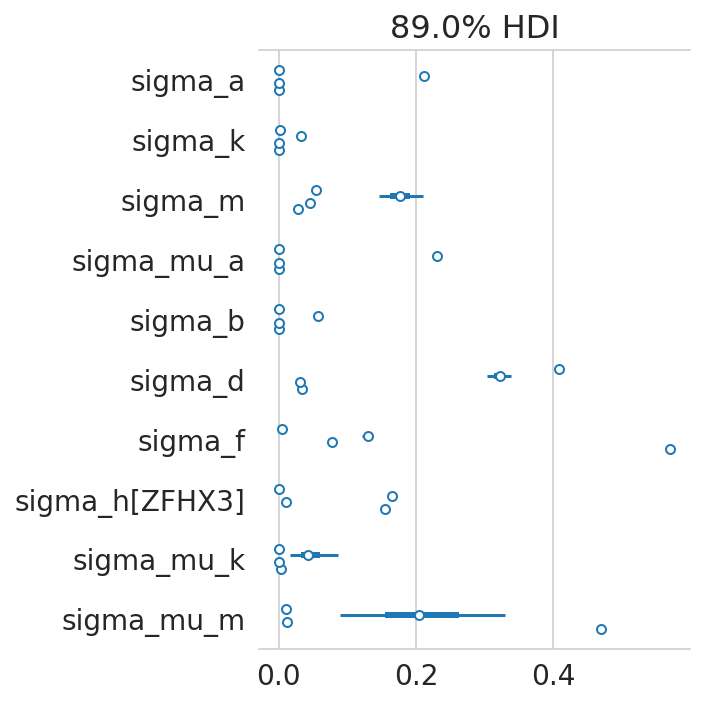

In [24]:
az.plot_forest(
    trace, var_names=["^sigma_*"], filter_vars="regex", combined=False, figsize=(5, 5)
)
plt.tight_layout()

In [25]:
trace.posterior = trace.posterior.sel(chain=HAPPY_CHAINS)

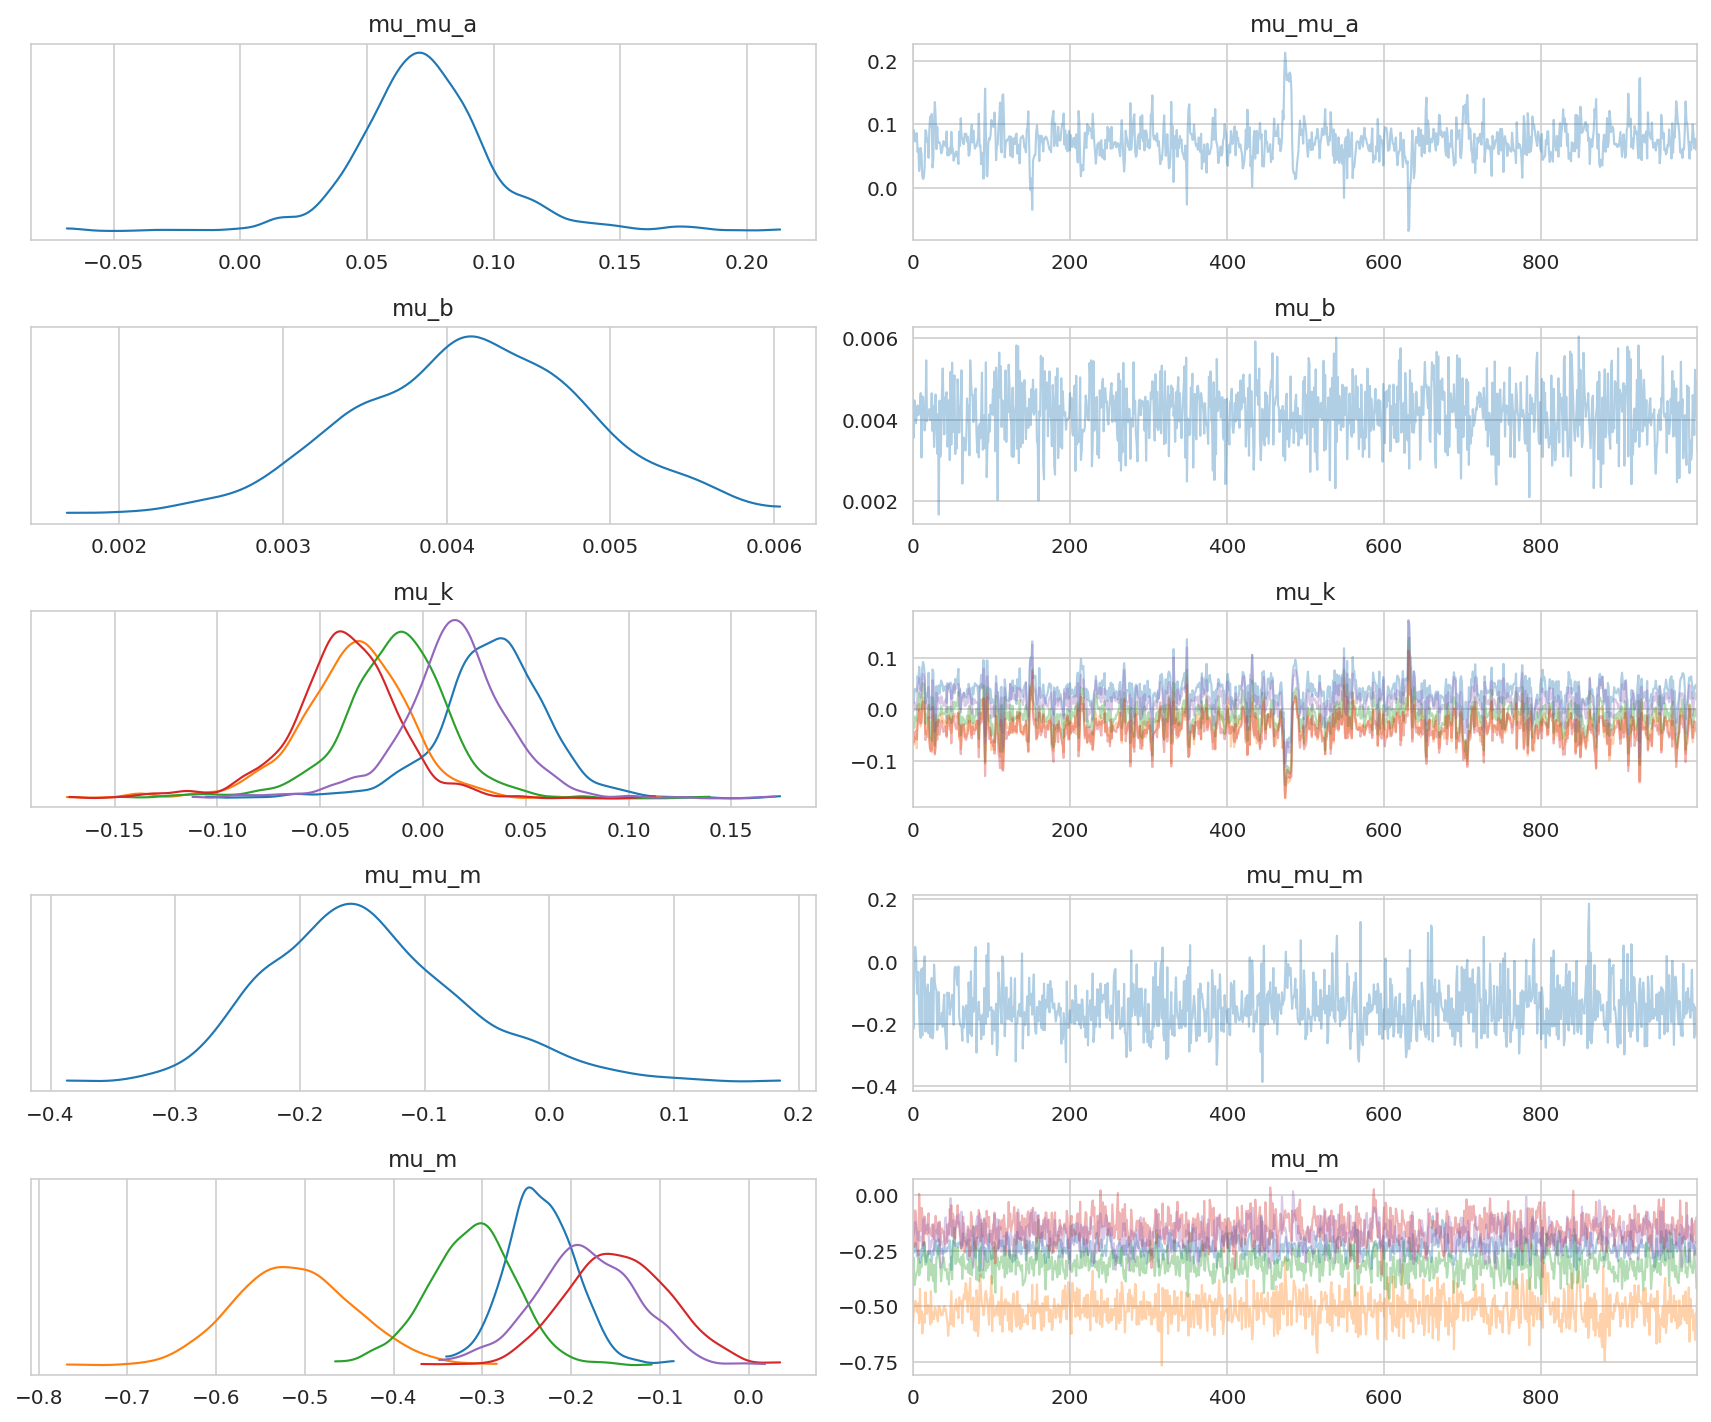

In [26]:
az.plot_trace(
    trace, var_names=["mu_mu_a", "mu_b", "mu_k", "mu_mu_m", "mu_m"], compact=True
)
plt.tight_layout()
plt.show()

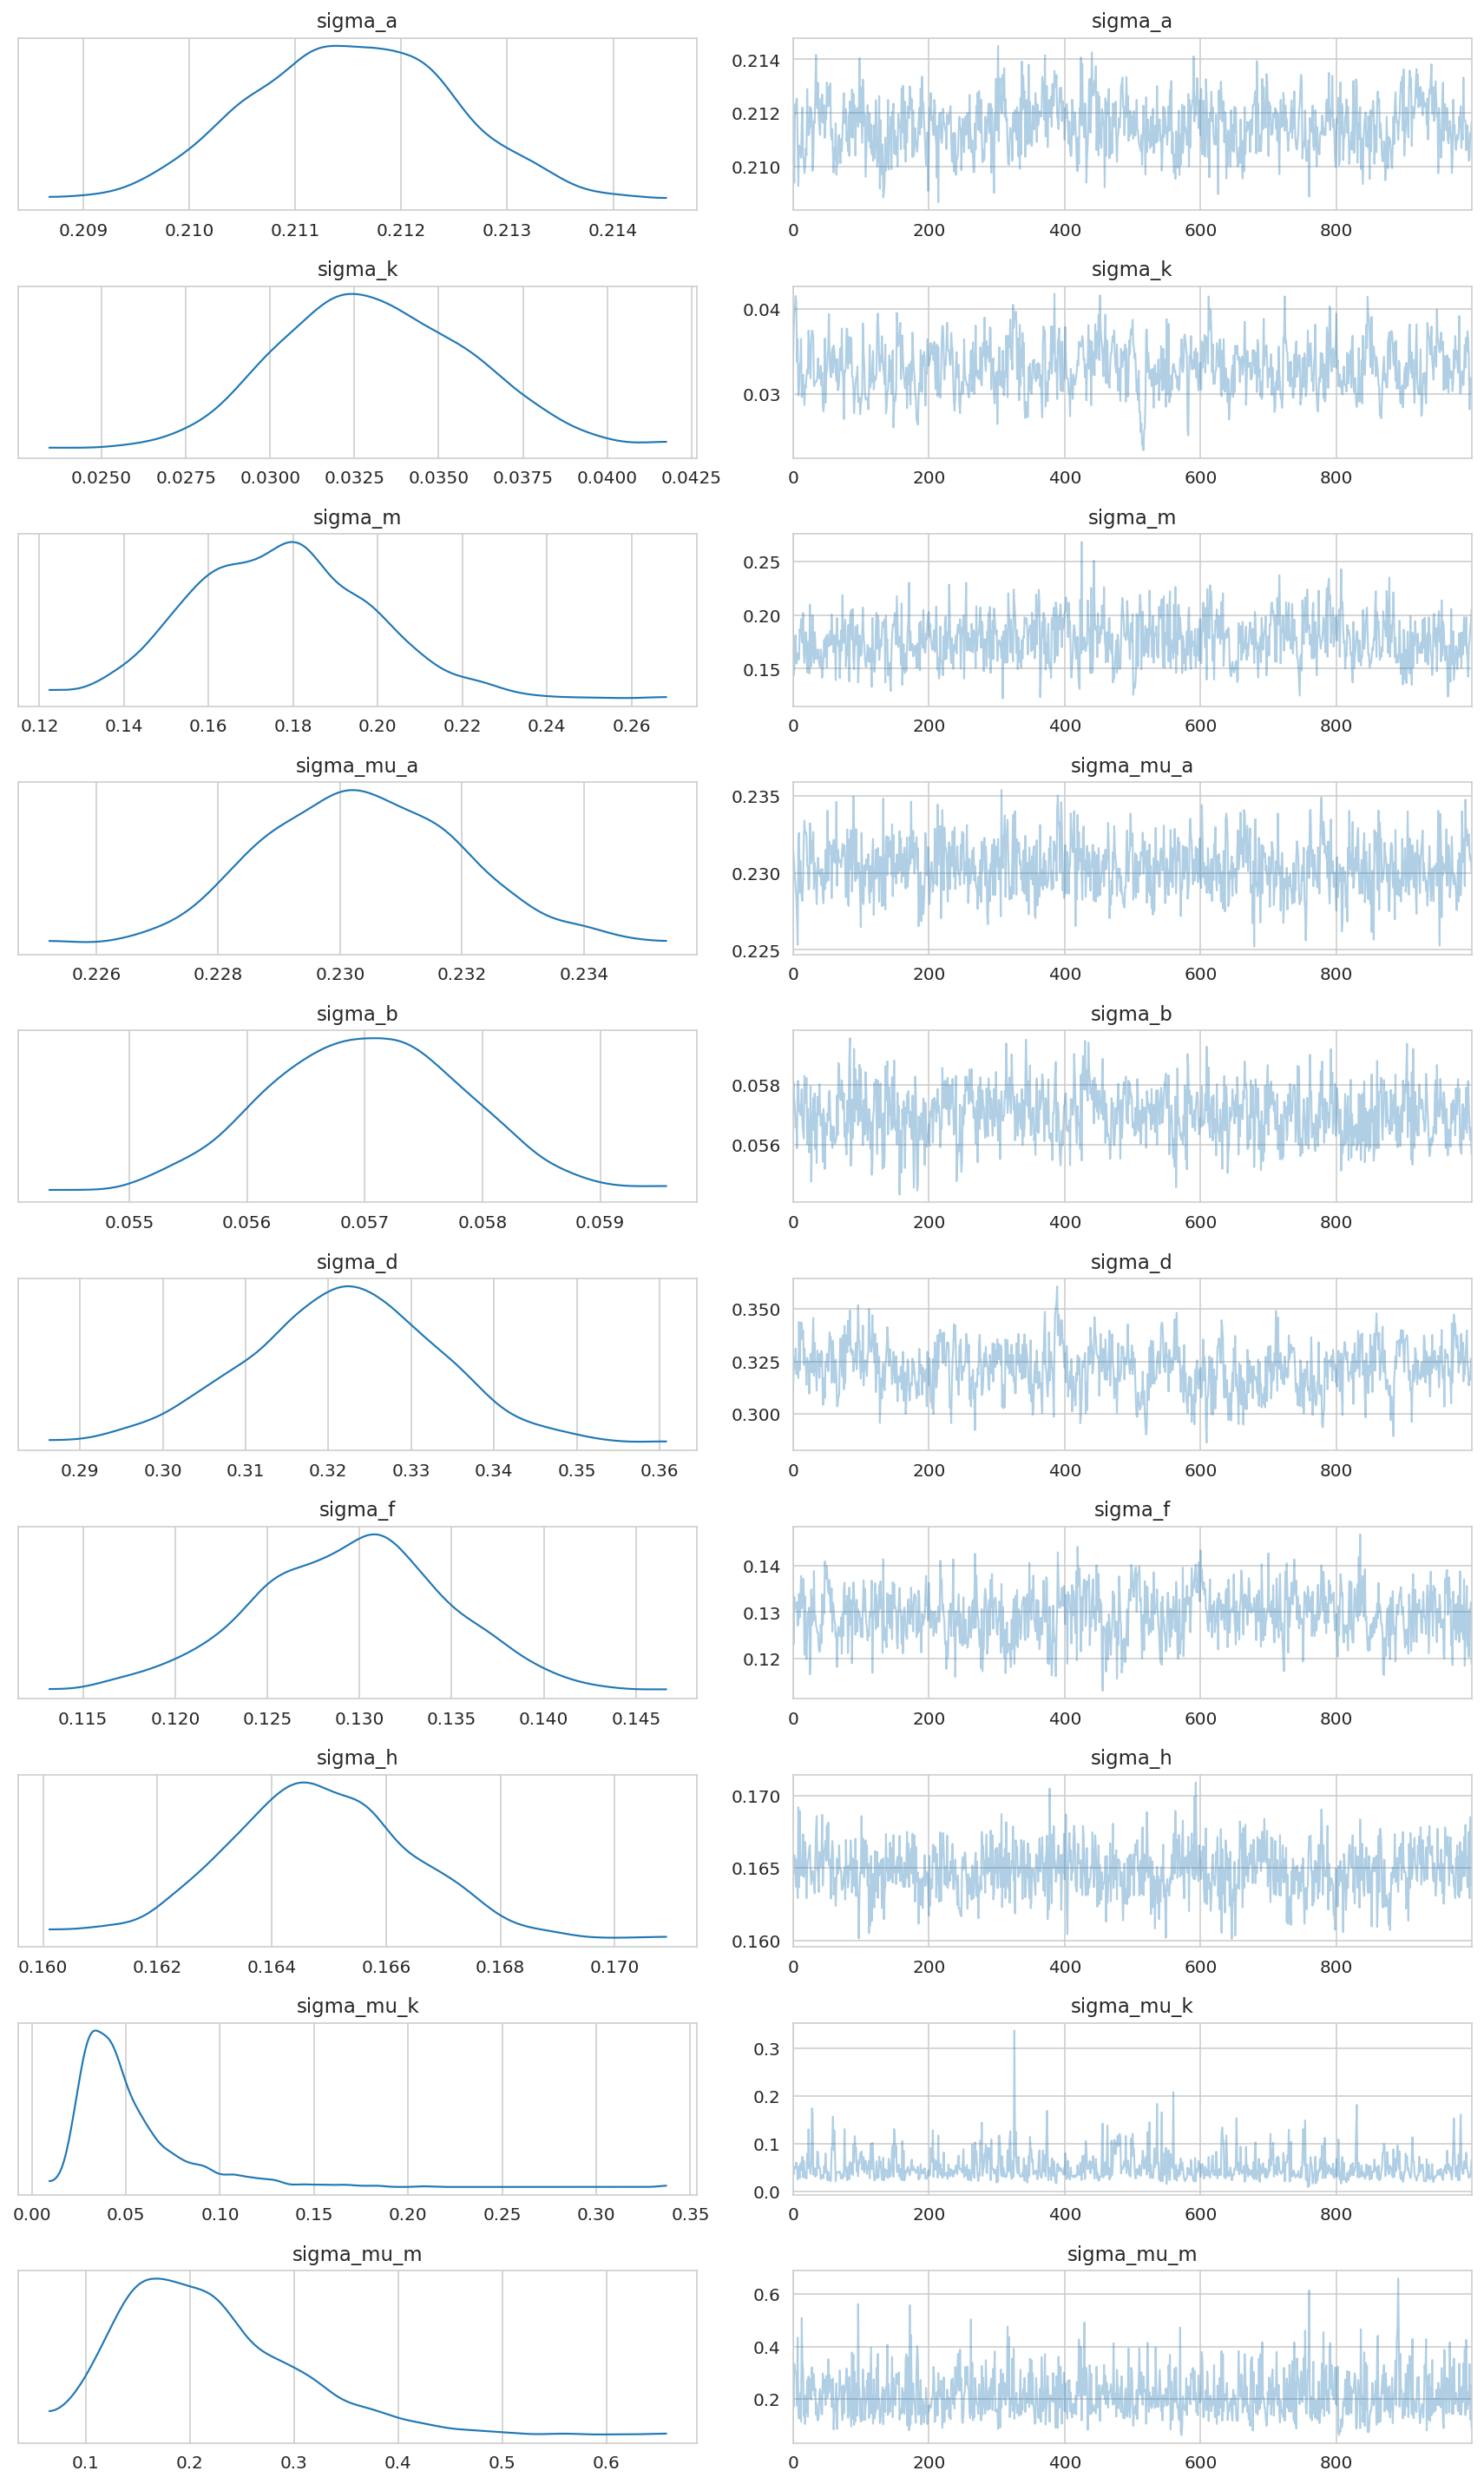

In [27]:
az.plot_trace(trace, var_names=["^sigma_*"], filter_vars="regex", compact=True)
plt.tight_layout()
plt.show()

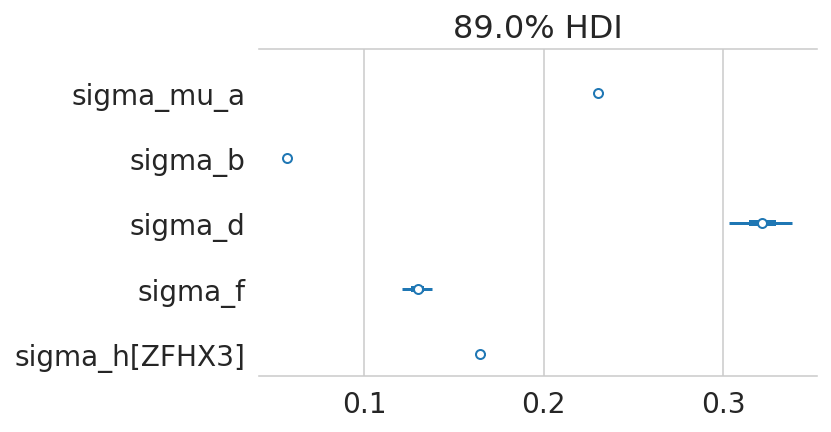

In [28]:
az.plot_forest(
    trace,
    var_names=["sigma_mu_a", "sigma_b", "sigma_d", "sigma_f", "sigma_h"],
    figsize=(5, 3),
    combined=True,
);

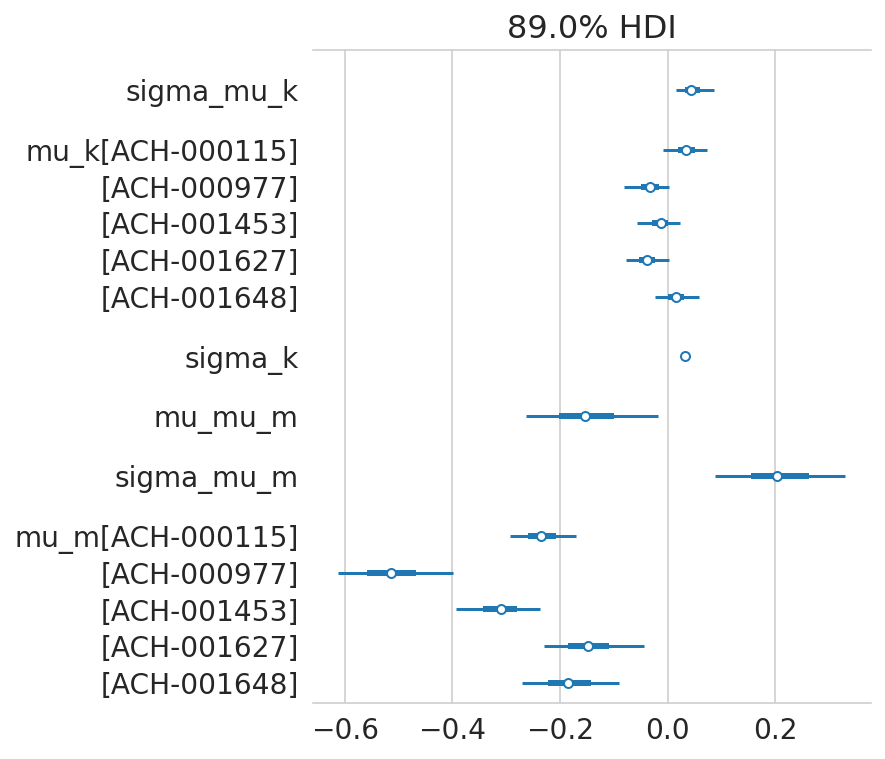

In [29]:
az.plot_forest(
    trace,
    var_names=["sigma_mu_k", "mu_k", "sigma_k", "mu_mu_m", "sigma_mu_m", "mu_m"],
    figsize=(5, 6),
    combined=True,
);

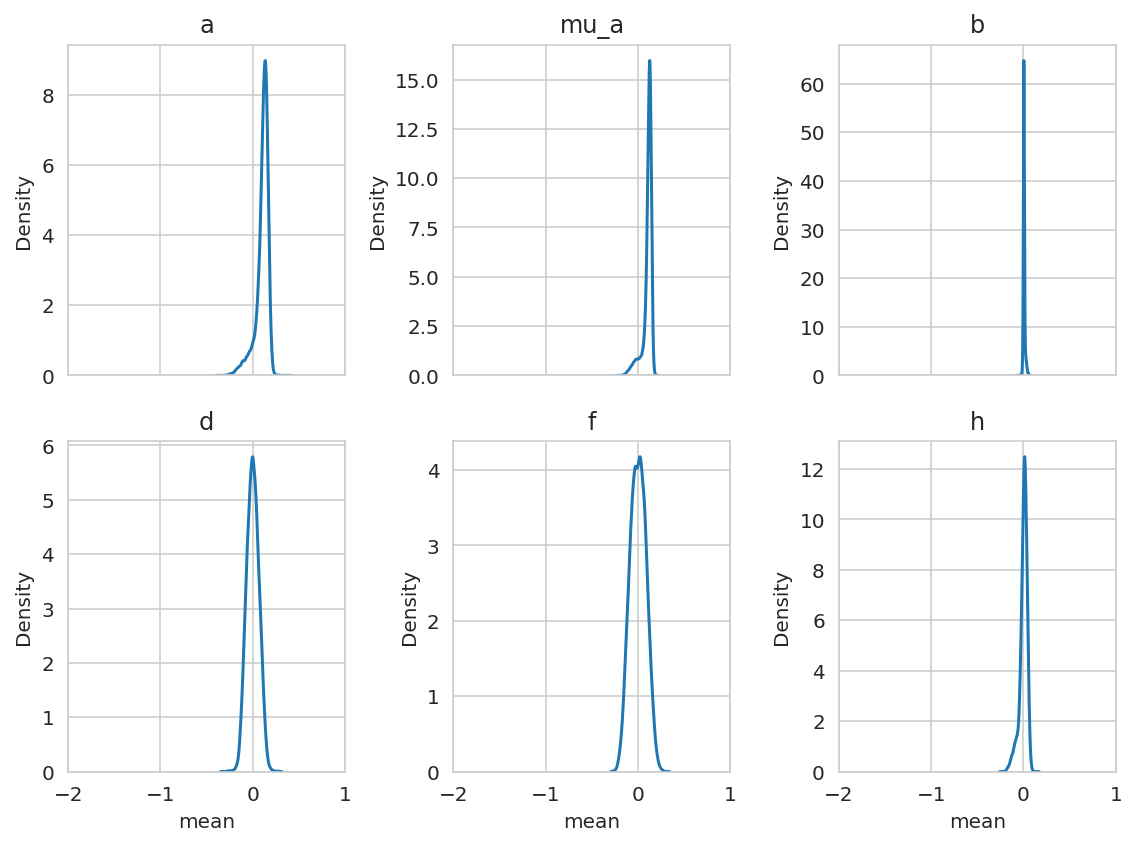

In [30]:
var_names = ["a", "mu_a", "b", "d", "f", "h"]
_, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True)
for ax, var_name in zip(axes.flatten(), var_names):
    x = prostate_post_summary.query(f"var_name == '{var_name}'")["mean"]
    sns.kdeplot(x=x, ax=ax)
    ax.set_title(var_name)
    ax.set_xlim(-2, 1)

plt.tight_layout()
plt.show()

In [31]:
sgrna_to_gene_map = (
    prostate_data.copy()[["hugo_symbol", "sgrna"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [32]:
for v in ["mu_a", "b", "d", "f", "h", "k", "m"]:
    display(Markdown(f"variable: **{v}**"))
    top = (
        prostate_post_summary.query(f"var_name == '{v}'")
        .sort_values("mean")
        .pipe(head_tail, 5)
    )
    display(top)

variable: **mu_a**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
7786      mu_a[KIF11] -0.218  0.573    -1.221      0.119      0.284    0.218   
6988      mu_a[HSPE1] -0.173  0.496    -1.044      0.119      0.246    0.188   
14745     mu_a[SPC24] -0.169  0.490    -1.025      0.119      0.243    0.186   
4440       mu_a[DUX4] -0.165  0.481    -1.005      0.119      0.239    0.182   
12654       mu_a[RAN] -0.165  0.481    -1.016      0.119      0.238    0.182   
941    mu_a[ARHGAP44]  0.185  0.137     0.100      0.420      0.064    0.049   
12058   mu_a[PRAMEF4]  0.186  0.138     0.100      0.420      0.065    0.049   
6763   mu_a[HLA-DQB1]  0.187  0.141     0.100      0.426      0.065    0.049   
16215      mu_a[TP53]  0.200  0.160     0.100      0.480      0.077    0.058   
2456       mu_a[CCNF]  0.202  0.166     0.100      0.485      0.078    0.059   

       ess_bulk  ess_tail  r_hat var_name  
7786        5.0      17.0   3.14     mu_a  
6988        5.0      17.0   3.15     mu_a  
14745       5.0      17.0   3.15     mu_a  
4440        5.0      17.0   3.14     mu_a  
12654       5.0      17.0   3.14     mu_a  
941         5.0      23.0   3.16     mu_a  
12058       5.0      23.0   2.89     mu_a  
6763        5.0      23.0   2.90     mu_a  
16215       5.0      23.0   3.16     mu_a  
2456        5.0      23.0   2.90     mu_a

variable: **b**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
22903    b[EP300] -0.079  0.150    -0.341      0.016      0.074    0.056   
34345     b[TP63] -0.041  0.086    -0.192      0.016      0.042    0.032   
33384    b[TADA1] -0.040  0.084    -0.187      0.016      0.041    0.031   
33099    b[STAG2] -0.039  0.081    -0.181      0.016      0.039    0.030   
24977   b[HOXB13] -0.037  0.079    -0.174      0.016      0.038    0.029   
27995  b[NDUFB11]  0.062  0.097     0.001      0.232      0.047    0.036   
19387  b[ATP6V1F]  0.062  0.098     0.001      0.234      0.048    0.036   
24317      b[GPI]  0.065  0.104     0.001      0.246      0.050    0.038   
27885    b[NARS2]  0.067  0.106     0.001      0.252      0.052    0.039   
18592    b[AIFM1]  0.073  0.117     0.001      0.278      0.057    0.044   

       ess_bulk  ess_tail  r_hat var_name  
22903       5.0      29.0   3.32        b  
34345       5.0      29.0   3.32        b  
33384       5.0      29.0   3.32        b  
33099       5.0      31.0   3.33        b  
24977       5.0      27.0   3.32        b  
27995       4.0      11.0   3.35        b  
19387       4.0      11.0   3.35        b  
24317       4.0      11.0   3.35        b  
27885       4.0      11.0   3.35        b  
18592       4.0      11.0   3.35        b

variable: **d**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
52956   d[UBE2N] -0.323  0.427    -1.046     -0.024      0.204    0.155   
40724   d[EARS2] -0.285  0.389    -0.934      0.010      0.182    0.138   
44643   d[LONP1] -0.285  0.367    -0.871      0.010      0.169    0.128   
44099    d[KLF5] -0.276  0.368    -0.885      0.017      0.174    0.132   
51054   d[SPPL3] -0.270  0.287    -0.591     -0.020      0.128    0.097   
47602   d[PFDN5]  0.260  0.286     0.002      0.559      0.127    0.096   
42314    d[GMPS]  0.271  0.326    -0.031      0.683      0.147    0.111   
38953    d[CDT1]  0.274  0.331    -0.013      0.786      0.154    0.117   
41624   d[FDFT1]  0.285  0.305     0.017      0.660      0.136    0.103   
45609  d[MRPL39]  0.290  0.366    -0.028      0.855      0.171    0.130   

       ess_bulk  ess_tail  r_hat var_name  
52956       5.0      28.0   3.41        d  
40724       4.0      11.0   3.48        d  
44643       4.0      15.0   3.28        d  
44099       5.0      21.0   3.25        d  
51054       6.0      25.0   2.38        d  
47602       6.0      20.0   2.19        d  
42314       5.0      15.0   2.58        d  
38953       4.0      13.0   3.21        d  
41624       5.0      14.0   2.53        d  
45609       5.0      28.0   2.97        d

variable: **f**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
63360     f[MEGF9] -0.261  0.344    -0.845     -0.000      0.169    0.131   
70149    f[TMBIM6] -0.260  0.412    -0.968      0.002      0.204    0.157   
61266   f[HRASLS2] -0.259  0.396    -0.938      0.005      0.196    0.151   
61235    f[HOXD11] -0.258  0.375    -0.899     -0.002      0.185    0.143   
56342   f[C7orf57] -0.254  0.381    -0.905     -0.004      0.188    0.145   
61786      f[ISCU]  0.262  0.318     0.002      0.779      0.157    0.121   
68912  f[SNRNP200]  0.264  0.287     0.001      0.728      0.140    0.108   
63725    f[MRPL36]  0.269  0.330     0.003      0.807      0.162    0.125   
67712   f[RSL24D1]  0.271  0.371    -0.007      0.889      0.183    0.141   
58986    f[EIF3CL]  0.304  0.411    -0.004      0.990      0.203    0.157   

       ess_bulk  ess_tail  r_hat var_name  
63360       6.0      28.0   2.47        f  
70149       6.0      22.0   2.72        f  
61266       6.0      13.0   2.73        f  
61235       6.0      29.0   2.49        f  
56342       6.0      14.0   2.85        f  
61786       5.0      13.0   3.19        f  
68912       5.0      18.0   2.81        f  
63725       5.0      14.0   3.30        f  
67712       5.0      22.0   3.82        f  
58986       5.0      23.0   3.13        f

variable: **h**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
156838   h[RPS4X, ZFHX3] -0.241  0.305    -0.754      0.001      0.151   
151324   h[KIF11, ZFHX3] -0.215  0.334    -0.799      0.000      0.165   
158283   h[SPC24, ZFHX3] -0.210  0.287    -0.701      0.000      0.141   
159963   h[TRNT1, ZFHX3] -0.209  0.310    -0.747     -0.000      0.153   
148218     h[ELL, ZFHX3] -0.206  0.327    -0.781     -0.000      0.162   
149500  h[GIMAP4, ZFHX3]  0.100  0.103    -0.000      0.223      0.048   
152541   h[MEGF9, ZFHX3]  0.102  0.116    -0.009      0.249      0.055   
150416  h[HOXD11, ZFHX3]  0.104  0.133    -0.008      0.309      0.064   
150212   h[HIP1R, ZFHX3]  0.105  0.121    -0.000      0.277      0.057   
148322   h[EP300, ZFHX3]  0.153  0.223    -0.002      0.541      0.110   

        mcse_sd  ess_bulk  ess_tail  r_hat var_name  
156838    0.115       4.0      12.0   3.37        h  
151324    0.126       5.0      17.0   3.10        h  
158283    0.108       4.0      17.0   3.30        h  
159963    0.117       5.0      22.0   3.02        h  
148218    0.124       4.0      11.0   3.34        h  
149500    0.037       5.0      13.0   2.47        h  
152541    0.042       5.0      15.0   2.53        h  
150416    0.049       5.0      19.0   2.99        h  
150212    0.043       5.0      24.0   2.79        h  
148322    0.084       5.0      28.0   3.22        h

variable: **k**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
161738  k[ACH-001453__12] -0.030  0.053    -0.121     -0.000      0.025   
161765  k[ACH-001627__16] -0.026  0.046    -0.104      0.000      0.022   
161719  k[ACH-000977__16] -0.023  0.044    -0.097      0.001      0.021   
161722  k[ACH-000977__19] -0.020  0.039    -0.085      0.001      0.018   
161766  k[ACH-001627__17] -0.019  0.037    -0.079      0.000      0.017   
161691  k[ACH-000115__11]  0.016  0.031    -0.001      0.069      0.014   
161793  k[ACH-001648__21]  0.016  0.031    -0.001      0.070      0.014   
161684   k[ACH-000115__4]  0.016  0.032    -0.001      0.072      0.015   
161776   k[ACH-001648__4]  0.018  0.035    -0.001      0.079      0.016   
161703   k[ACH-000115__X]  0.019  0.036    -0.000      0.081      0.016   

        mcse_sd  ess_bulk  ess_tail  r_hat var_name  
161738    0.019       4.0      16.0   3.53        k  
161765    0.017       5.0      25.0   3.13        k  
161719    0.016       5.0      16.0   3.09        k  
161722    0.014       5.0      16.0   3.39        k  
161766    0.013       5.0      21.0   3.19        k  
161691    0.010       5.0      15.0   2.97        k  
161793    0.010       5.0      17.0   3.06        k  
161684    0.011       5.0      27.0   3.05        k  
161776    0.012       5.0      16.0   3.21        k  
161703    0.012       5.0      14.0   3.14        k

variable: **m**

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
161825   m[ACH-000977__7] -0.478  0.180    -0.730     -0.293      0.077   
161822   m[ACH-000977__4] -0.465  0.168    -0.696     -0.294      0.074   
161837  m[ACH-000977__19] -0.461  0.111    -0.590     -0.335      0.054   
161831  m[ACH-000977__13] -0.454  0.133    -0.641     -0.336      0.059   
161824   m[ACH-000977__6] -0.447  0.126    -0.575     -0.280      0.059   
161890   m[ACH-001648__3] -0.191  0.054    -0.271     -0.131      0.025   
161852  m[ACH-001453__11] -0.187  0.146    -0.318      0.030      0.065   
161861  m[ACH-001453__20] -0.185  0.151    -0.335      0.052      0.071   
161906  m[ACH-001648__19] -0.178  0.086    -0.311     -0.081      0.042   
161893   m[ACH-001648__6] -0.169  0.106    -0.268     -0.012      0.041   

        mcse_sd  ess_bulk  ess_tail  r_hat var_name  
161825    0.058       5.0      17.0   2.36        m  
161822    0.056       5.0      19.0   2.30        m  
161837    0.041       5.0      16.0   2.48        m  
161831    0.045       5.0      29.0   2.54        m  
161824    0.045       5.0      17.0   2.16        m  
161890    0.020       5.0      15.0   2.32        m  
161852    0.052       5.0      17.0   2.79        m  
161861    0.056       5.0      15.0   3.23        m  
161906    0.033       4.0      15.0   3.20        m  
161893    0.031       6.0      28.0   2.22        m

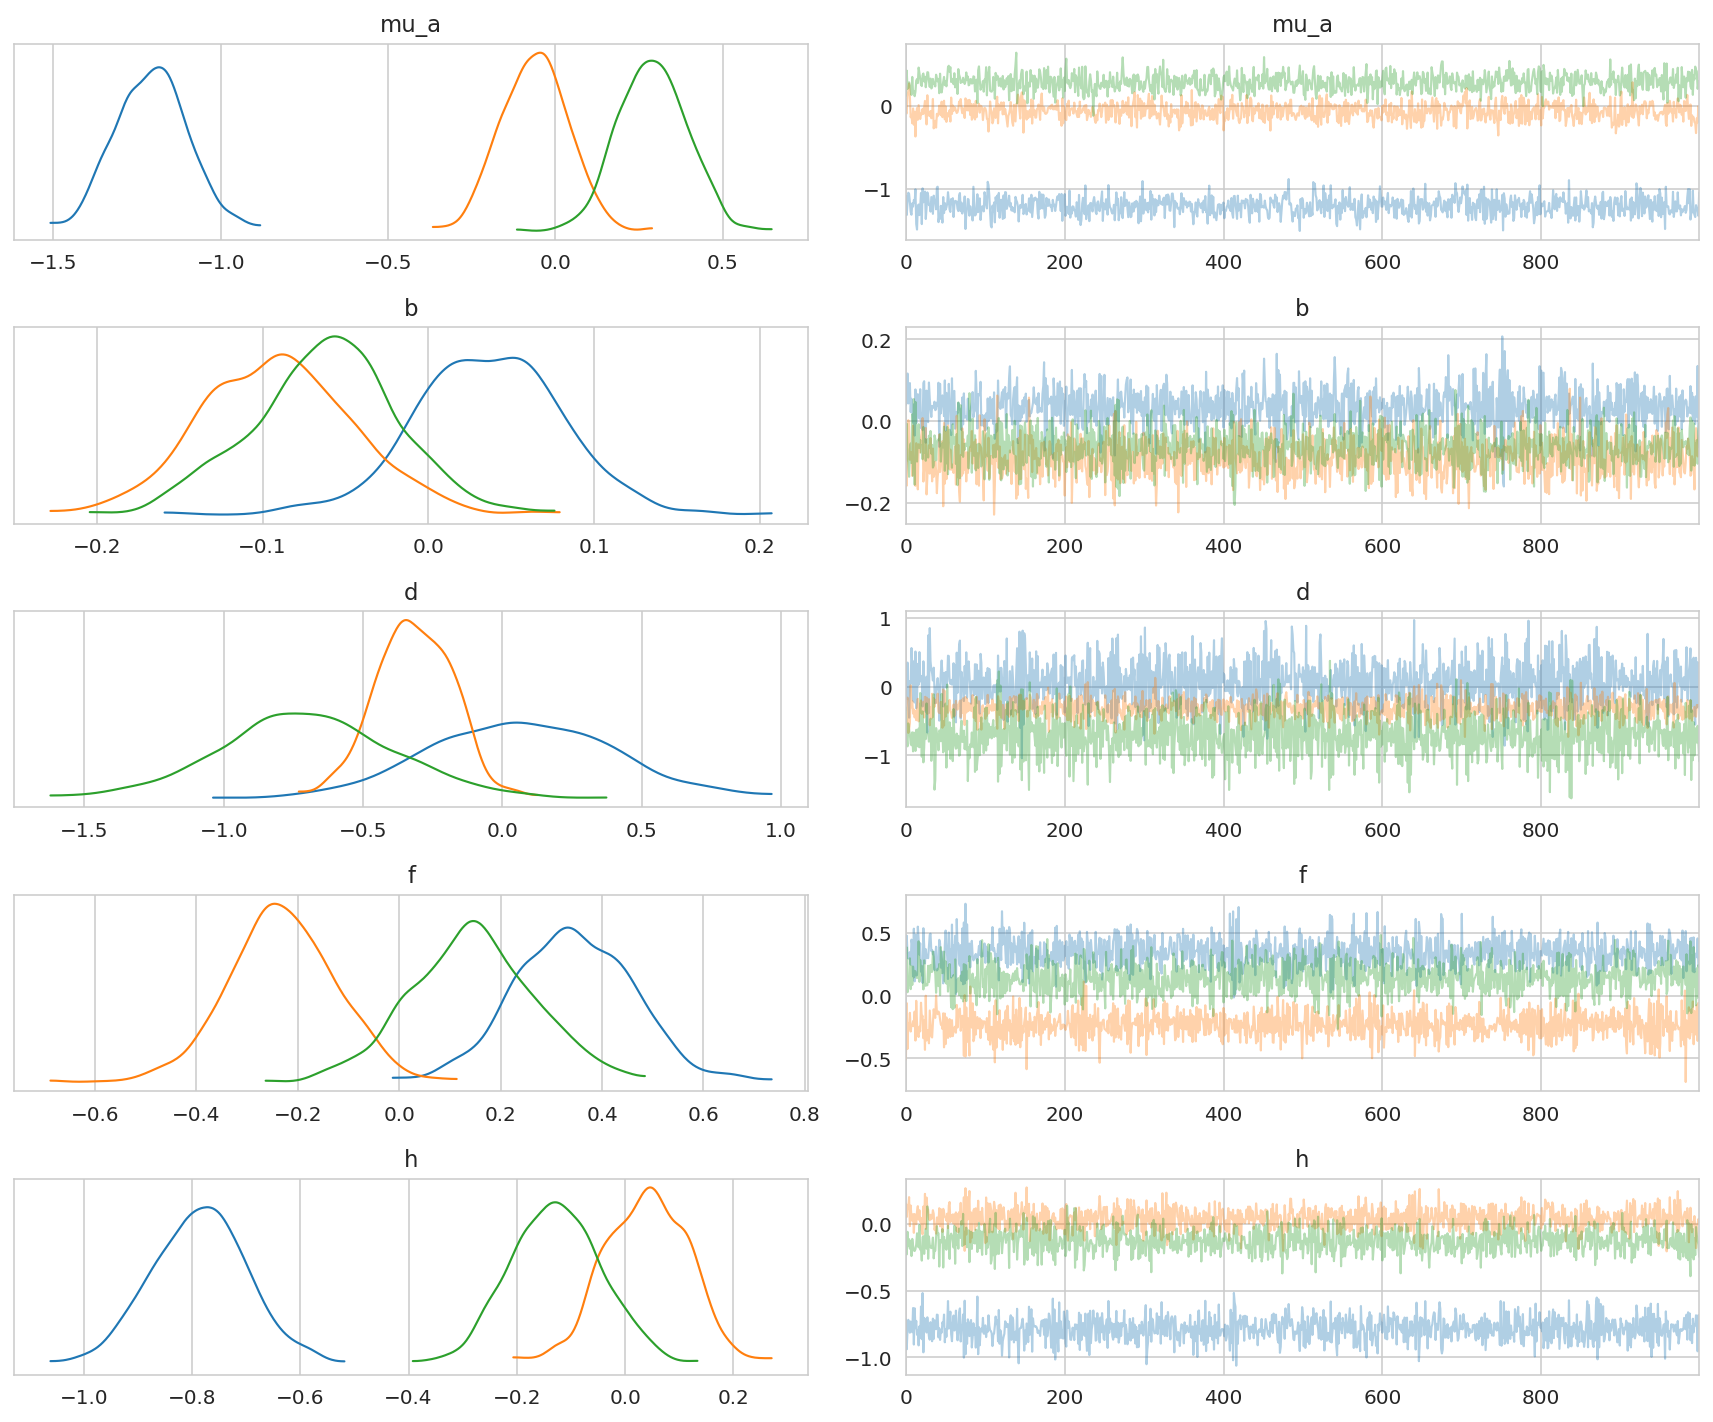

In [33]:
example_genes = ["KIF11", "AR", "NF2"]
az.plot_trace(
    trace,
    var_names=["mu_a", "b", "d", "f", "h"],
    coords={"gene": example_genes},
    compact=True,
)
plt.tight_layout()
plt.show()

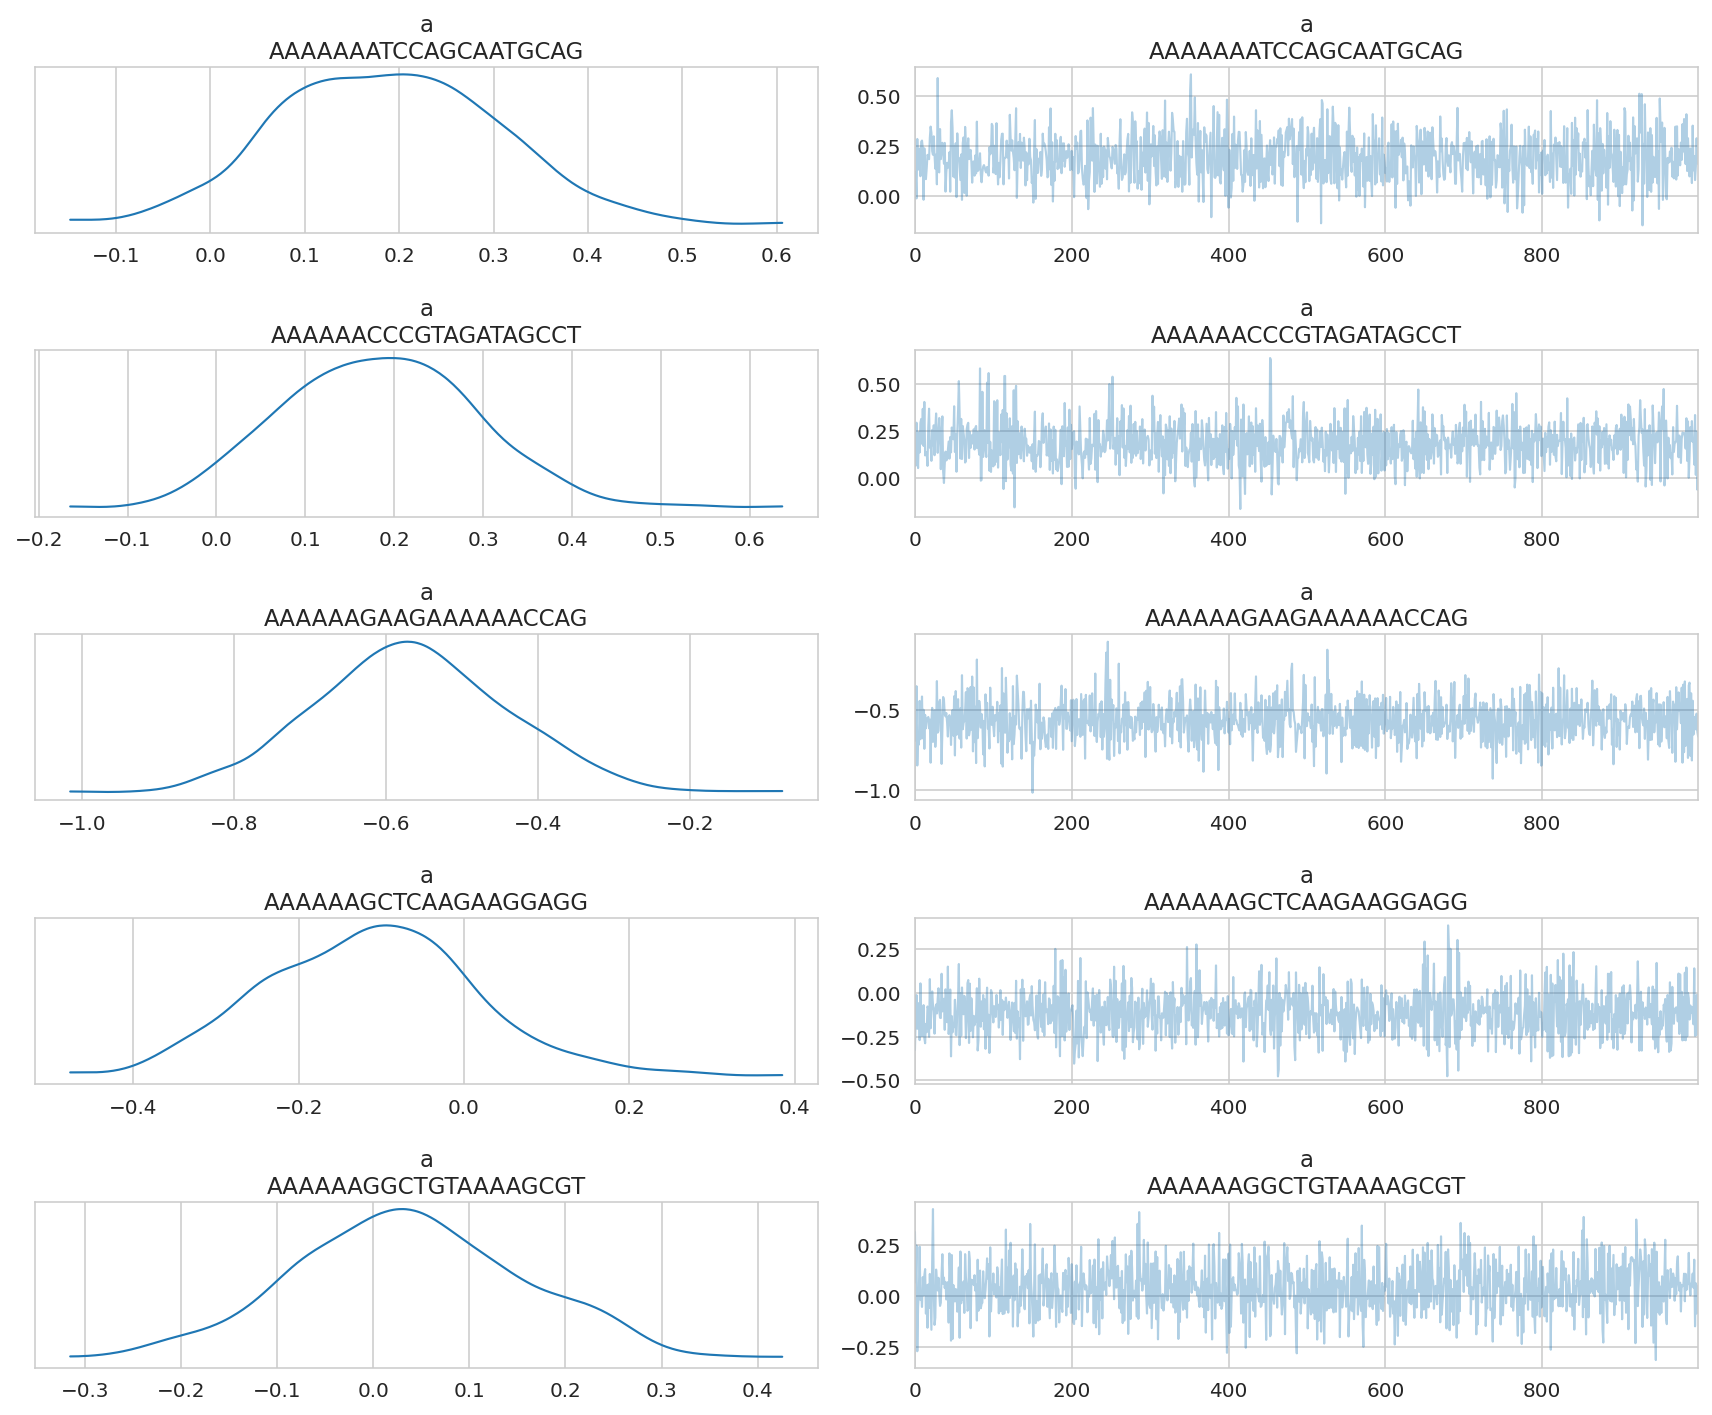

In [34]:
sgrnas_sample = trace.posterior.coords["sgrna"].values[:5]

az.plot_trace(trace, var_names="a", coords={"sgrna": sgrnas_sample}, compact=False)
plt.tight_layout()
plt.show()

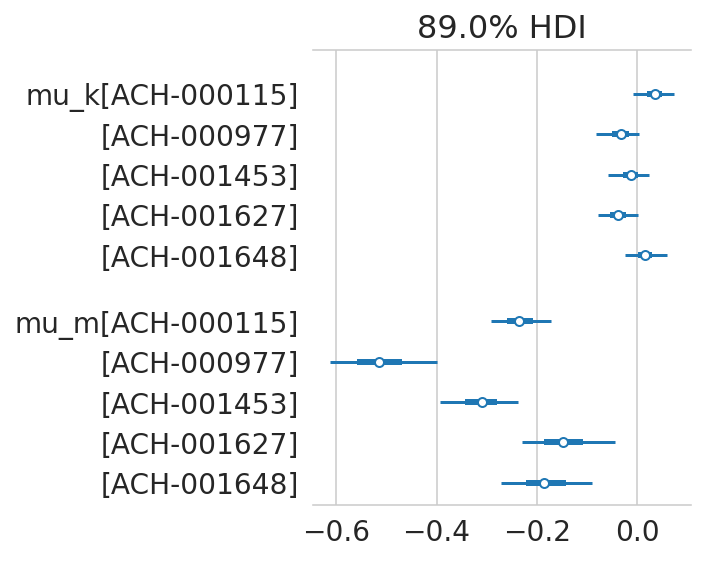

In [35]:
az.plot_forest(trace, var_names=["mu_k", "mu_m"], combined=True, figsize=(5, 4))
plt.tight_layout()
plt.show()

In [36]:
cell_chromosome_map = (
    valid_prostate_data[["depmap_id", "sgrna_target_chr", "cell_chrom"]]
    .drop_duplicates()
    .sort_values("cell_chrom")
    .reset_index(drop=True)
)

In [37]:
chromosome_effect_post = (
    az.summary(trace, var_names=["k", "m"], kind="stats")
    .pipe(extract_coords_param_names, names="cell_chrom")
    .assign(var_name=lambda d: [p[0] for p in d.index.values])
    .merge(cell_chromosome_map, on="cell_chrom")
)

cell_effect_post = (
    az.summary(trace, var_names=["mu_k", "mu_m"], kind="stats")
    .pipe(extract_coords_param_names, names="depmap_id")
    .assign(var_name=lambda d: [p[:4] for p in d.index.values])
    .reset_index(drop=True)
    .pivot_wider(
        index="depmap_id",
        names_from="var_name",
        values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
    )
)

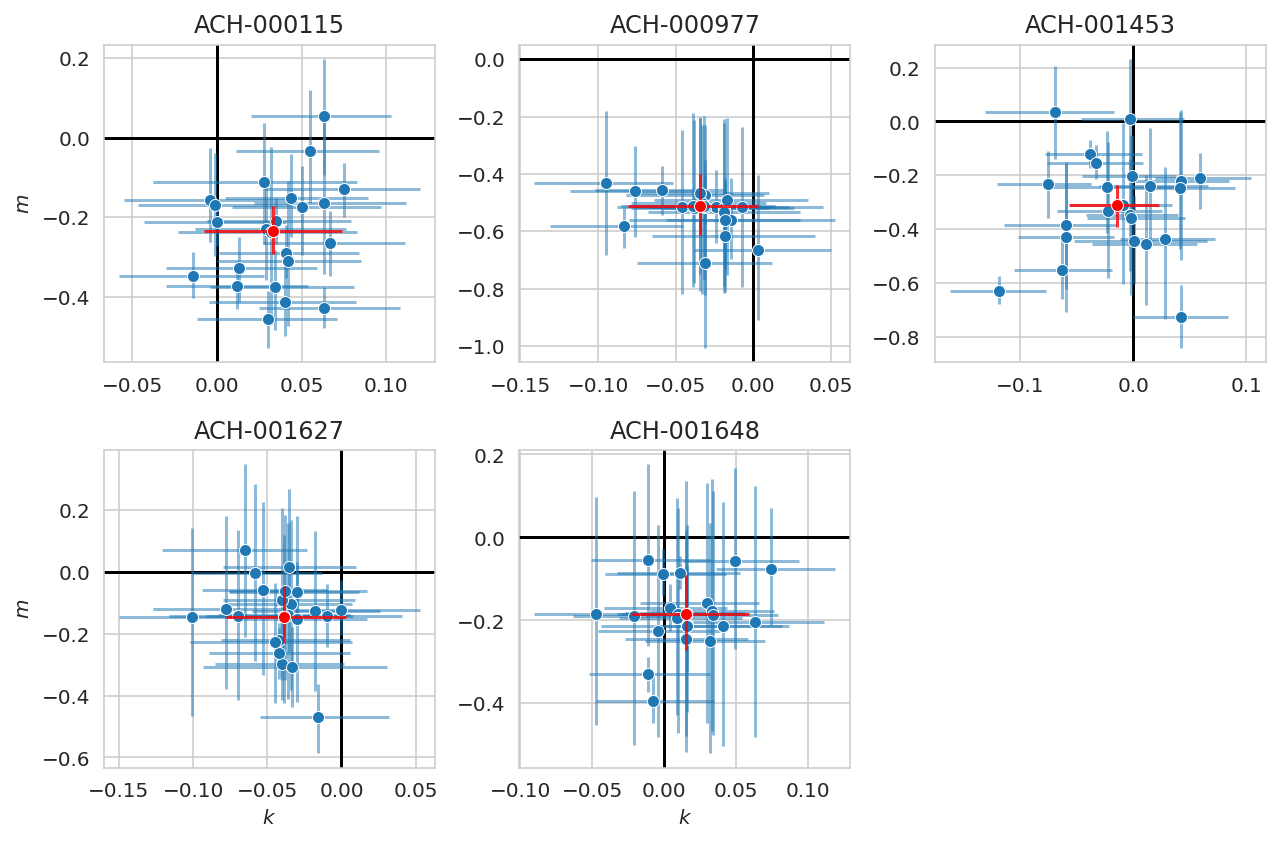

In [38]:
ncells = chromosome_effect_post["depmap_id"].nunique()
ncols = 3
nrows = ceil(ncells / 3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, nrows * 3))
for ax, (cell, data_c) in zip(
    axes.flatten(), chromosome_effect_post.groupby("depmap_id")
):
    plot_df = data_c.pivot_wider(
        index="sgrna_target_chr",
        names_from="var_name",
        values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
    )
    cell_eff = (
        cell_effect_post.copy().query(f"depmap_id == '{cell}'").reset_index(drop=True)
    )

    ax.axhline(0, color="k", zorder=1)
    ax.axvline(0, color="k", zorder=1)

    ax.vlines(
        x=plot_df["mean_k"],
        ymin=plot_df["hdi_5.5%_m"],
        ymax=plot_df["hdi_94.5%_m"],
        alpha=0.5,
        zorder=5,
    )
    ax.hlines(
        y=plot_df["mean_m"],
        xmin=plot_df["hdi_5.5%_k"],
        xmax=plot_df["hdi_94.5%_k"],
        alpha=0.5,
        zorder=5,
    )
    sns.scatterplot(data=plot_df, x="mean_k", y="mean_m", ax=ax, zorder=10)

    ax.vlines(
        x=cell_eff["mean_mu_k"],
        ymin=cell_eff["hdi_5.5%_mu_m"],
        ymax=cell_eff["hdi_94.5%_mu_m"],
        alpha=0.8,
        zorder=15,
        color="red",
    )
    ax.hlines(
        y=cell_eff["mean_mu_m"],
        xmin=cell_eff["hdi_5.5%_mu_k"],
        xmax=cell_eff["hdi_94.5%_mu_k"],
        alpha=0.8,
        zorder=15,
        color="red",
    )
    sns.scatterplot(
        data=cell_eff, x="mean_mu_k", y="mean_mu_m", ax=ax, zorder=20, color="red"
    )
    ax.set_title(cell)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

for ax in axes[-1, :]:
    ax.set_xlabel("$k$")
for ax in axes[:, 0]:
    ax.set_ylabel("$m$")
for ax in axes.flatten()[ncells:]:
    ax.axis("off")

fig.tight_layout()
plt.show()

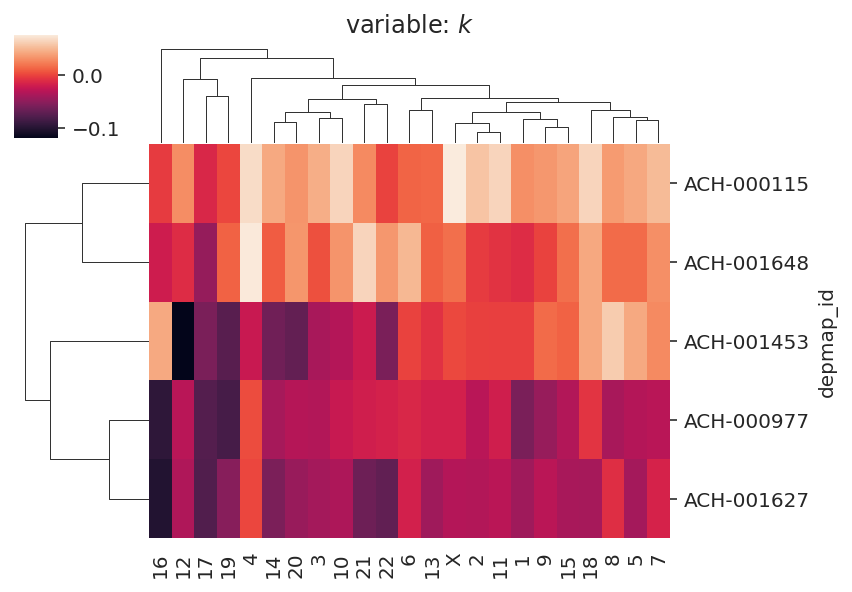

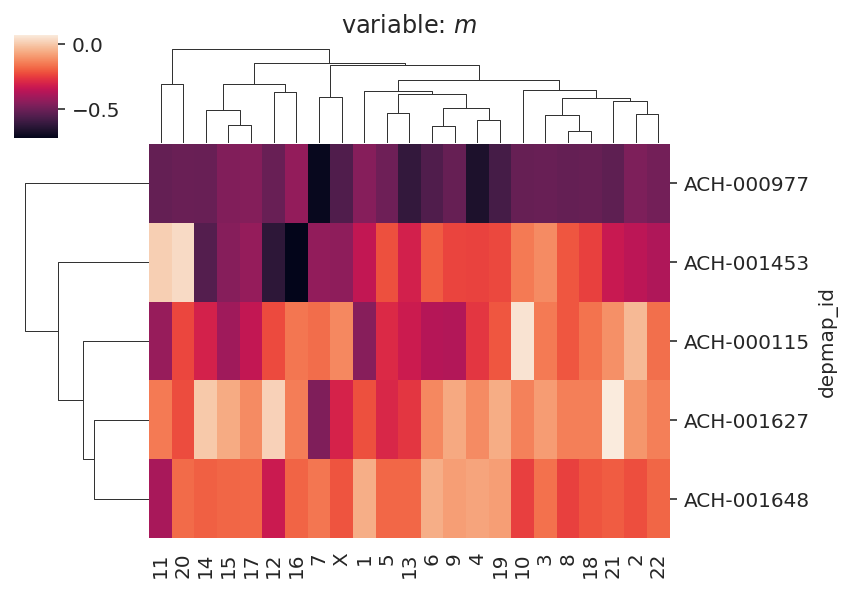

In [39]:
for v, data_v in chromosome_effect_post.groupby("var_name"):
    df = (
        data_v.copy()
        .reset_index(drop=True)
        .pivot_wider(
            index="depmap_id", names_from="sgrna_target_chr", values_from="mean"
        )
        .set_index("depmap_id")
    )
    cg = sns.clustermap(df, figsize=(6, 4))
    cg.ax_col_dendrogram.set_title(f"variable: ${v}$")
    plt.show()

In [40]:
genes_var_names = ["mu_a", "b", "d", "f"]
genes_var_names += [f"h[{g}]" for g in trace.posterior.coords["cancer_gene"].values]
gene_corr_post = (
    az.summary(trace, "genes_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .astype({"d1": int, "d2": int})
    .assign(
        p1=lambda d: [genes_var_names[i] for i in d["d1"]],
        p2=lambda d: [genes_var_names[i] for i in d["d2"]],
    )
    .assign(
        p1=lambda d: pd.Categorical(d["p1"], categories=d["p1"].unique(), ordered=True)
    )
    .assign(
        p2=lambda d: pd.Categorical(
            d["p2"], categories=d["p1"].cat.categories, ordered=True
        )
    )
)

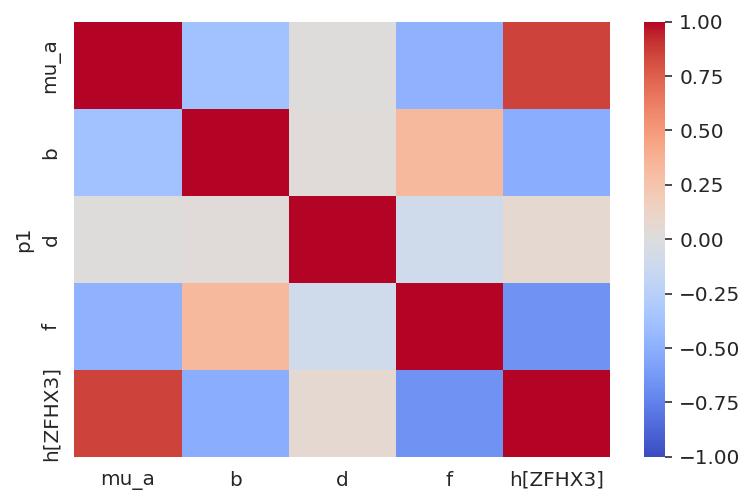

In [41]:
plot_df = gene_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

In [42]:
cancer_genes = trace.posterior.coords["cancer_gene"].values.tolist()
cancer_gene_mutants = (
    valid_prostate_data.filter_column_isin("hugo_symbol", cancer_genes)[
        ["hugo_symbol", "depmap_id", "is_mutated"]
    ]
    .drop_duplicates()
    .assign(is_mutated=lambda d: d["is_mutated"].map({True: "X", False: ""}))
    .pivot_wider("depmap_id", names_from="hugo_symbol", values_from="is_mutated")
    .set_index("depmap_id")
)
cancer_gene_mutants

ZFHX3
depmap_id       
ACH-000115      
ACH-000977     X
ACH-001453      
ACH-001627     X
ACH-001648

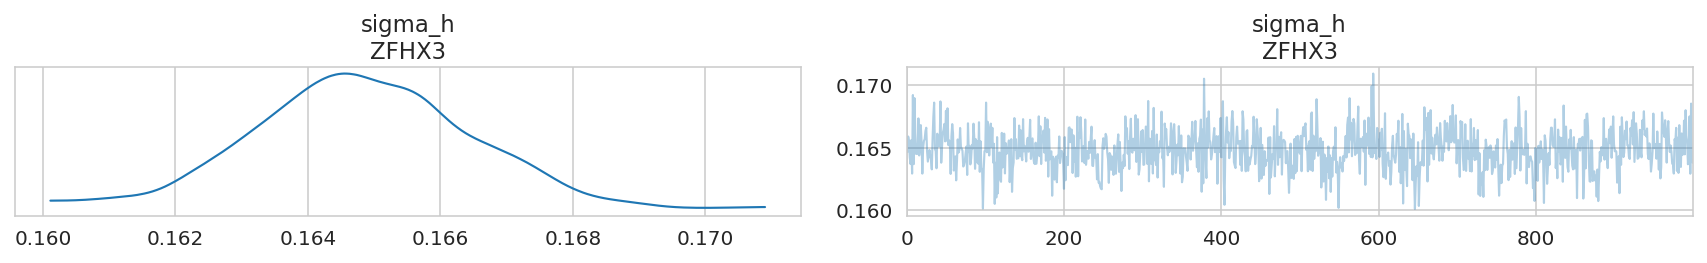

In [43]:
az.plot_trace(trace, var_names=["sigma_h"], compact=False)
plt.tight_layout()
plt.show()

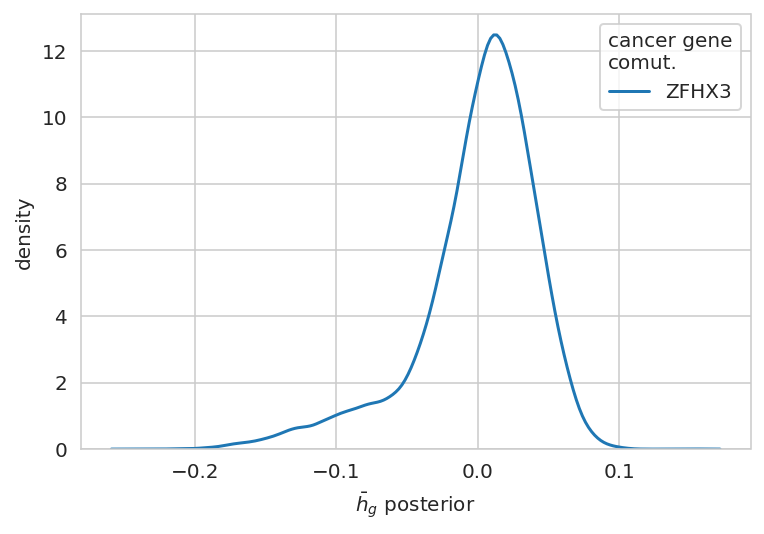

In [44]:
h_post_summary = (
    prostate_post_summary.query("var_name == 'h'")
    .reset_index(drop=True)
    .pipe(
        extract_coords_param_names,
        names=["hugo_symbol", "cancer_gene"],
        col="parameter",
    )
)

ax = sns.kdeplot(data=h_post_summary, x="mean", hue="cancer_gene")
ax.set_xlabel(r"$\bar{h}_g$ posterior")
ax.set_ylabel("density")
ax.get_legend().set_title("cancer gene\ncomut.")
plt.show()

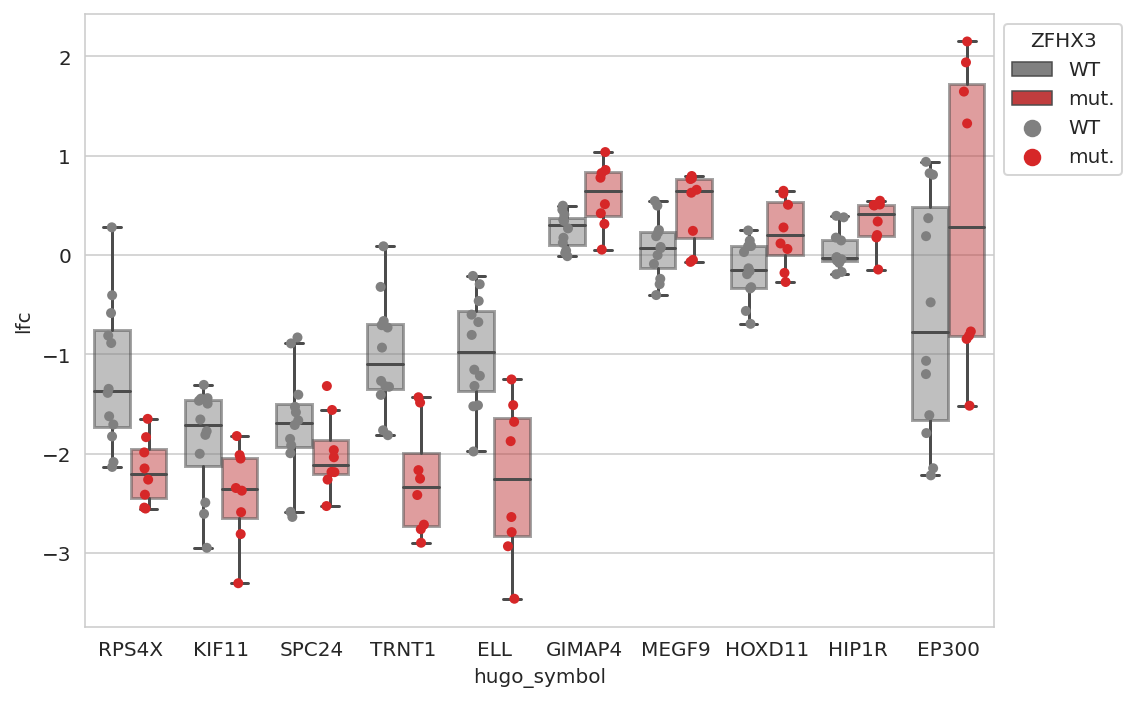

In [45]:
fig, axes = plt.subplots(
    len(cancer_genes), 1, squeeze=False, figsize=(8, len(cancer_genes) * 5)
)
for ax, cg in zip(axes.flatten(), cancer_genes):
    h_hits = (
        h_post_summary.filter_column_isin("cancer_gene", [cg])
        .sort_values("mean")
        .pipe(head_tail, n=5)["hugo_symbol"]
        .tolist()
    )

    h_hits_data = (
        valid_prostate_data.filter_column_isin("hugo_symbol", h_hits)
        .merge(cancer_gene_mutants.reset_index(), on="depmap_id")
        .reset_index()
        .astype({"hugo_symbol": str})
        .assign(
            hugo_symbol=lambda d: pd.Categorical(d["hugo_symbol"], categories=h_hits),
            _cg_mut=lambda d: d[cg].map({"X": "mut.", "": "WT"}),
        )
    )
    mut_pal = {"mut.": "tab:red", "WT": "gray"}
    sns.boxplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        palette=mut_pal,
        ax=ax,
        showfliers=False,
        boxprops={"alpha": 0.5},
    )
    sns.stripplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        dodge=True,
        palette=mut_pal,
        ax=ax,
    )
    sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1), title=cg)

plt.tight_layout()
plt.show()

---

## Session info

In [46]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 2.41 minutes


In [47]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-08-08

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-170.o2.rc.hms.harvard.edu

Git branch: varying-chromosome

seaborn   : 0.11.2
arviz     : 0.12.1
matplotlib: 3.5.2
numpy     : 1.23.1
pandas    : 1.4.3

